In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.cm as mplcm
import matplotlib.colors as colors
import re
from scipy.signal import savgol_filter
from math import ceil, floor
from sklearn.linear_model import LogisticRegression
from pathlib import Path
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
import warnings
from statsmodels.stats.proportion import proportion_confint
import requests, json, time
# from pymuller import muller

In [2]:
#GT smoothed, Look at the trajectories to get the humps moved up, rename b117 in files to variant, plot the scalers for age/variant/both

#### Comparison with Angie's method

In [ ]:
# #GISAID Data
# metadata = pd.read_csv("../variant_data/metadata.tsv", sep="\t", parse_dates = ["Collection date", "Submission date"])
# metadata["alias"] = metadata["Virus name"].apply(lambda row: "/".join(row.split("/")[2:]))

# #NCBI data from curl command with complete_only=false and annotated_only=false
# all_ncbi = pd.read_csv("../variant_data/all_ncbi_covid_genomes.csv")
# # print(all_ncbi.shape)
# all_ncbi = all_ncbi.dropna(subset=["Isolate Name"])
# all_ncbi["alias"] = all_ncbi["Isolate Name"].apply(lambda row: row.split(",")[0].split(" isolate ")[-1])
# all_ncbi.alias = all_ncbi.alias.apply(lambda row: "/".join(row.split("/")[-2:]))

# #Angie's join data
# join_data = pd.read_table("../variant_data/epiToPublic.tsv", header=None, low_memory=True)
# join_data.columns = ["EPI", "Accession", "name", "date"]

# #Angie Overlap
# angie_epis = list(set(metadata["Accession ID"]) & set(join_data.EPI))
# angie_overlap = metadata[metadata["Accession ID"].isin(angie_epis)][["Accession ID", "alias", "Virus name", "Submission date"]]

# #My Overlap
# my_overlap = metadata[metadata.alias.isin(list(set(metadata.alias) & set(all_ncbi.alias)))][["Accession ID", "alias", "Virus name", "Submission date"]]
# my_overlap = my_overlap[my_overlap["Submission date"] <= angie_overlap["Submission date"].max()]

# #In mine but not hers
# only_in_mine = my_overlap[~my_overlap["Accession ID"].isin(angie_epis)]

# #In hers but not mine
# only_in_hers = angie_overlap[~angie_overlap["Accession ID"].isin(my_overlap["Accession ID"])]

### Setup

In [2]:
#5% by 29th of May
# - when the states cross
# may 1 and june 25th
#617 delta
#Names at WHO

plot_path = Path("/sfs/qumulo/qproject/biocomplexity/COVID-19_commons/data/variants/plots")

state_to_stfips_path ="/project/biocomplexity/COVID-19_commons/2019-nCoV_stat-analyses/misc_data/stfips_to_state.csv"
state_to_stfips_df = pd.read_csv(state_to_stfips_path, header=None, dtype={"2":str})
state_to_stfips_df[2] = state_to_stfips_df[2].astype(str).str.zfill(2)
state_to_stfips = state_to_stfips_df.set_index(0)[2].to_dict()
state_to_stfips = state_to_stfips_df.set_index(0)[2].to_dict()
state_to_state_abbr = state_to_stfips_df.set_index(0)[1].to_dict()
stfips_to_state_abbr = state_to_stfips_df.set_index(2)[1].to_dict()
abbr_to_stfips = state_to_stfips_df.set_index(1)[2].to_dict()

# join_data = pd.read_csv("../variant_data/epiToPublic_USA.tsv", sep="\t", header=None)
join_data = pd.read_table("../variant_data/epiToPublic.tsv", header=None, low_memory=True)
join_data.columns = ["EPI", "Accession", "name", "date"]

accession_to_epi = join_data.set_index("Accession")["EPI"].to_dict()
gis_accessions = join_data.Accession.tolist()

def convert_state_stfips(state):
    try:
        return state_to_stfips[state]
    except:
        return np.nan
    
def convert_abbr_stfips(abbr):
    try:
        return abbr_to_stfips[abbr]
    except:
        return np.nan
        
def convert_accession_epi(accession):
    try:
        return accession_to_epi[accession]
    except:
        return np.nan

In [3]:
metadata = pd.read_csv("../variant_data/metadata.tsv", sep="\t", parse_dates = ["Collection date", "Submission date"])
# print(metadata.columns)
# metadata = metadata[["Accession ID", \
#                    "Collection date", \
#                    "Submission date", \
#                    "Location", \
#                    "Additional location information", \
#                    "Sequence length", \
#                    "Host", \
#                    "AA Substitutions", \
#                    "Is reference?", \
#                    "Pango lineage"]]
def get_nth_slash(row, n):
    try:
        return row.split("/")[n].strip()
    except:
        return np.nan
    
for i in range(4):
    metadata[f"Location_{i}"] = metadata["Location"].apply(lambda row: get_nth_slash(row, i))
metadata = metadata.rename(columns={"Location_1":"country", "Location_2":"state"})
metadata = metadata[metadata["country"] == "USA"]
metadata["alias"] = metadata["Virus name"].apply(lambda row: "/".join(row.split("/")[2:]))
# metdata = metadata.rename(columns={"Accession ID":"EPI"})

/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2020.11-py3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (5,13,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
va_meta = metadata[metadata.state == "Virginia"]

In [26]:
va_meta["is_DCLS"] = va_meta.alias.apply(lambda row: 1 if "DCLS" in row else 0)

<ipython-input-26-a05d28498fb8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  va_meta["is_DCLS"] = va_meta.alias.apply(lambda row: 1 if "DCLS" in row else 0)


In [54]:
prefix = re.compile("\D*")
non_dcls = va_meta[va_meta["is_DCLS"] == 0].alias.unique()

In [57]:
for i in set([prefix.findall(i)[0] for i in non_dcls]):
    print(i)

VA-SU-SC_
VA-NIDDL-
VA-USAFSAM-S
VA-CDC-STM-A
VA_
VA-CDC-STM-
VA-NHRC-OID_
VA-GD-
HI-H
VA-CDCBI-CRSP_
VA-Yale-
VA-CDC-LC
VA-UW-
VA-CDC-MMB
VA-PLMI-HNY
VA-CDC-ASC
VA-CDC-
VA-HP
VA-SU-SC-
VA-OHSU-
VA-CDC-IBX
VA-GD-SID-
VA-UNM-IBL
VA-CDCBI-CRSP_FZR
VA-CDC-FG-
VA-FG-
VA-CDC-QDX
VA-Curative-
USA/VA-
VA-PNCV
VA_NIDDL_
VA-SEARCH-
VA-Noblis-S
VA-VSP
VA-NM-
VA-QDX-
VA-MASPHL-
VA-EPICC-S
VA-CAV_VAS


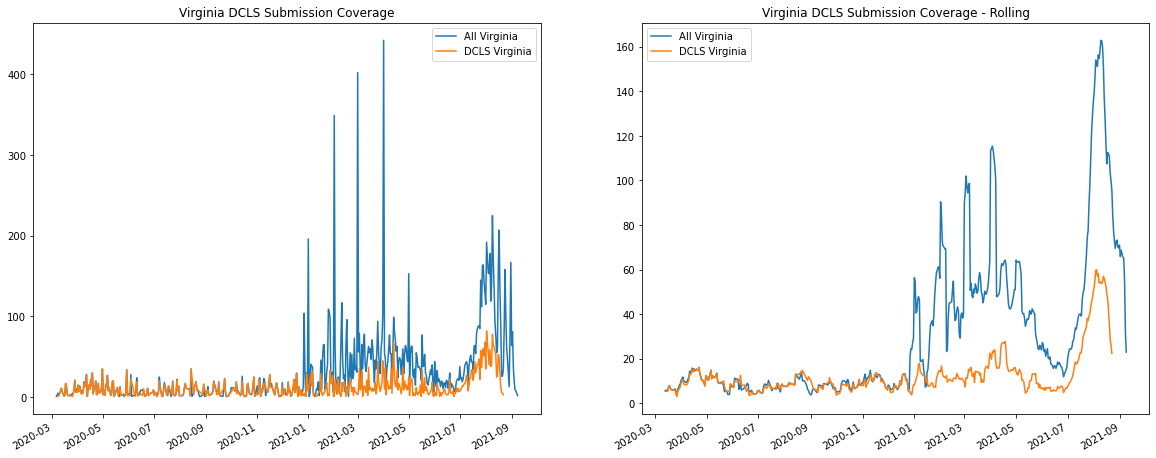

In [42]:
fig, axs = plt.subplots(ncols = 2, figsize=(20,8))

ax=axs[0]
va_meta["Collection date"].value_counts().sort_index().plot(ax=ax, label="All Virginia")
va_meta[va_meta.is_DCLS == 1]["Collection date"].value_counts().sort_index().plot(ax=ax, label = "DCLS Virginia") #.count()["alias"].plot()
ax.legend()
ax.set_title("Virginia DCLS Submission Coverage")

ax=axs[1]
va_meta["Collection date"].value_counts().sort_index().rolling(7).mean().plot(ax=ax, label="All Virginia")
va_meta[va_meta.is_DCLS == 1]["Collection date"].value_counts().sort_index().rolling(7).mean().plot(ax=ax, label = "DCLS Virginia") #.count()["alias"].plot()
ax.legend()
ax.set_title("Virginia DCLS Submission Coverage - Rolling")
plt.savefig("virginia_dcls_gisaid_coverage.png", dpi=100, facecolor="white")

<AxesSubplot:>

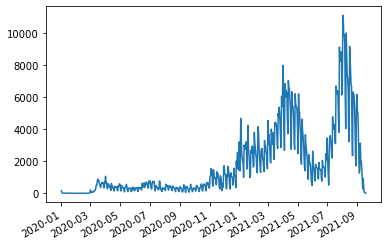

In [8]:
metadata["Collection date"].value_counts().plot()

In [9]:
metadata["Collection date"].max()

Timestamp('2021-09-18 00:00:00')

In [4]:
ncbi = pd.read_csv("../variant_data/sequences.csv", parse_dates=["Release_Date"])
ncbi["is_USA"] = ncbi["Geo_Location"].apply(lambda row: True if "USA" in str(row) else False)
ncbi = ncbi[ncbi.is_USA]
all_usa_ncbi = ncbi.shape
print(ncbi.shape[0], "NCBI from the US")

ncbi = ncbi.dropna(subset=["GenBank_Title"])
ncbi["alias"] = ncbi["GenBank_Title"].apply(lambda row: row.split(",")[0].split(" isolate ")[-1].split("USA/")[-1])

accession_to_epi = join_data.set_index("Accession")["EPI"].to_dict()
ncbi["EPI"] = ncbi.Accession.apply(convert_accession_epi)

377077 NCBI from the US


In [5]:
t = ncbi.alias.value_counts()
t[t>1].sum()

5635

In [6]:
ncbi = ncbi[(~ncbi.EPI.isin(metadata["Accession ID"])) & (~ncbi.alias.isin(metadata.alias))] # #.shape
# ncbi[~ncbi.alias.isin(metadata.alias)]
only_ncbi = ncbi.shape
ncbi = ncbi[~ncbi.USA.isna()][["Collection_Date", "Pangolin", "USA", "Release_Date"]]
ncbi.columns = ["date", "variant", "state", "submission_date"]
ncbi.date = pd.to_datetime(ncbi.date)
ncbi.state = ncbi.state.apply(convert_abbr_stfips)
ncbi = ncbi.dropna()
print(all_usa_ncbi[0] - only_ncbi[0], "in NCBI and GISAID")
print(only_ncbi[0], "in NCBI only")

metadata = metadata[["Collection date", "Pango lineage", "state", "Submission date"]]
metadata.columns = ["date", "variant", "state", "submission_date"]
metadata.date = pd.to_datetime(metadata.date)
metadata.state = metadata.state.apply(convert_state_stfips)
metadata = metadata.dropna()

347409 in NCBI and GISAID
29668 in NCBI only


In [7]:
def get_state_variants(state, rolling=False, normalize=True):
    
    variant_names = variants.variant.unique()
    
    if state in ["US", "USA", "ALL"]:
        data = variants.copy()
    else:    
        data = variants[variants.state == state].sort_values("date")
    data = data.groupby(["date", "variant"]).count().reset_index()
    data = data.pivot(index="date", columns="variant", values="state").fillna(0)
    samples = data.sum(axis=1)
        
#     data = data.iloc[:-10] #Take out noisy last 10 days
    if rolling:
#         data = data.resample("7D").sum().copy()
        data = data.rolling(7).mean()
    else:  
        data = data.apply(lambda col: savgol_filter(col, 31, 1), axis=0)
        
#         data = data.rolling(7).mean()
#     else:
#         data = data.resample("14D").sum()
    data = data.where(data > 0, other=0)
    data.other = data.other.replace(0, 0.001)
    if normalize:
        data = data.divide(data.sum(axis=1), axis=0)
    for column in set(variant_names) - set(data.columns):
        data[column] = 0
    data["samples"] = samples
    data["days"] = data.index
    data.days = (data.days - data.index.min()).dt.days
    
    if state in ["US", "USA"]:
        data = data[data.samples > 200]
#     else:
#         data = data[data.samples > 10]
        
#     data = data.loc["2020-10-01":]
    
    return data

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(20,8))

ax=axs[0]
x = get_state_variants("US", rolling=True)
twinx = ax.twinx()
x["samples"].plot(ax=twinx, alpha=0.6)
x.drop(columns=["samples", "days"]).plot(ax=ax)
ax.set_title("US Rolling Average", fontsize=18)

ax = axs[1]
x = get_state_variants("US")
twinx = ax.twinx()
x["samples"].plot(ax=twinx, alpha=0.6)
x.drop(columns=["samples", "days"]).plot(ax=ax)
ax.set_title("US Savgol Smoothing", fontsize=18)

plt.savefig("us_savgol_vs_rolling_anomaly.png", dpi=100, facecolor="white")

#### Description of logistic projection

**Data Source**
* The data comes from GISAID and NCBI Virus, both of which include pangolin lineage assignment for each sample. 
* The samples are deduplicated by comparing sequence names and with the biweekly updated file from the CDC which maps NCBI accessions to GISAID EPI IDs (source: https://github.com/CDCgov/SARS-CoV-2_Sequencing/blob/master/files/epiToPublic.tsv.gz). Some duplicates may still exist. 
* Only data past 01-01-2021 are considered.

**Data Prep**
* The samples are grouped by state (those without a location are thrown out) and date.
* The variants are either taken as is, or grouped by some prefix (e.g. B.1.42X or B.1.617.X)
* The curves for each variant are independently smoothed using a savgol filter with a 31 day window length and a poly order of 1 to reduce noise. The result of this smoothing (and for a simple 7 day rolling average smoothing) are plotted.
* The variant proportions are then calculated for each time point, and the data is converted to long format with the variant name, proportion, and 
* A multinomial logistic model (sklearn.linear_model.LogisticRegression with multi_class='multinomial') is then fit to the data, using the number of days since 01-01-2021 as the independent variable, the name of the variant as the class labels (Y), and the number of samples that day which corresponded to that variant (x100) as the sample weight.
* The model is then used to estimate variant proportions in the future (next 60 days)

In [8]:
def train_state_prevalence_model(data):
    
#     data = data[["other", "B.1.1.7", "days", "samples"]]
    variants = len(data.columns) - 2
    long_data = data.melt(id_vars=["days", "samples"])
    long_data.samples = long_data.samples * 100 #So small numbers are still considered
    long_data.samples = long_data.samples * long_data.value
    # long_data.samples = long_data.samples.apply(lambda row: ceil(max(1, row)))
#     long_data.samples = long_data.samples.apply(lambda row: ceil(row)).replace(0, np.nan)
    long_data.samples = long_data.samples.apply(lambda row: floor(row)).replace(0, np.nan)
    long_data = long_data.dropna().sort_values("days").drop(columns=["value"])
#     return data, long_data
#     print(long_data.max())
    
#     print(long_data)
    if variants > 1:
        model = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=5000, random_state=42)
    else:
        model = LogisticRegression(solver="lbfgs", max_iter=5000, random_state=42)
        
    model.fit(long_data.days.to_numpy().reshape(-1,1), long_data.variant, sample_weight=long_data.samples)
        
    return model

def predict_variants(state, num_days_out=60, rolling=False, start_at="2021-01-01", variants = []):
    
    data = get_state_variants(state, rolling=rolling)
#     print(variants)
    if variants:
        variants += ["samples", "days"]
        non_var_cols = [c for c in data.columns if c not in variants]
        data["other"] = data[non_var_cols].sum(axis=1)
        data = data[variants + ["other"]]
#     print(data)
    data = data.loc[start_at:]
    data.days = data.apply(lambda row: (row.index - data.index.min()).days)["days"]
#     data = data.loc["2020-11-01":]
#     data = data.reindex(pd.date_range(start=np.datetime64("2020-08-01"), end=data.index.max())).ffill().bfill()
    
#     print(data.days.max())
    variant_names = sorted([c for c in data.columns if c not in ["samples", "days"]])
#     data[variant_names].plot(figsize=(10,8))
    
#     data.samples = data.apply(lambda row: row.samples * (1 + get_days_from_end_sample_weighing(data.days.max() - row.days, int(data.samples.max() / 60))), axis=1)
#     data.samples = data.apply(lambda row: row.samples if data.days.max() - row.days > 60 else data.samples.max(), axis=1)    
#     data.samples = (data.days).astype(int) + 50

#     return train_state_prevalence_model(data)
    data = data[set(data.columns)]
    model = train_state_prevalence_model(data)
    num_days = (data.index.max() - data.index.min()).days + num_days_out
    
    x_pred = np.array(range(0, num_days)).reshape(-1,1)
    preds = model.predict_proba(x_pred)
    preds = pd.DataFrame(preds, columns=model.classes_)
    preds.index = pd.Series(preds.index).apply(lambda row: data.index.min() + np.timedelta64(row, "D"))
    for column in set(variant_names) - set(preds.columns):
        preds[column] = 0
#     preds = preds[sorted(preds.columns)]
#     preds = preds[sorted(to_plot_names)]
    preds = preds[sorted(variant_names)]
        
    return preds, data[["samples"]]

def plot_variant_predictions(state, ax, num_days_out=60, stackplot=True, rolling=False):
    plot_names = [i for i in to_plot_names if i not in ["samples", "days"]]
#     print(plot_names)
    variants, samples = predict_variants(state, num_days_out=num_days_out, rolling=rolling, variants=plot_names)
#     samples.plot(figsize=(10,8))
    
    last_gt = (variants.index.max() - np.timedelta64(num_days_out, "D"))
    past_variants = variants.loc[:last_gt]
    future_variants = variants.loc[last_gt + np.timedelta64(1, "D"):]
    if stackplot:
        ax.set_prop_cycle(color=terrain_variant_colors)
#         ax.stackplot(variants.index, variants.T, labels=variants.columns)
        ax.stackplot(past_variants.index, past_variants.T, labels=past_variants.columns)
        ax.set_prop_cycle(color=terrain_variant_colors)
    
        ax.stackplot(future_variants.index, future_variants.T, labels=[], alpha=0.5)
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1], loc="upper left")
        lines = handles
    else:
        ax.set_prop_cycle(color=tab_variant_colors)
        lines = ax.plot(past_variants.index, past_variants, linewidth=4)
        ax.set_prop_cycle(color=tab_variant_colors)
        
        ax.plot(future_variants.index, future_variants, linewidth=4)
        ax.legend(lines[::-1], past_variants.columns[::-1], loc="upper left")
#         ax.bar(samples)
#         samples.plot(kind="bar")
    
    ax.axvline(variants.index.max() - np.timedelta64(num_days_out, "D"), color="k", linestyle="--", linewidth=2)
    ax.set_ylim(0,1)
    ax.set_xlim(variants.index.min(), variants.index.max())
    try:
        above_5 = variants["B.1.617.2"]
        above_5 = above_5[above_5 >= 0.05].index.min()
    except:
        above_5 = variants["B.1.617"]
        above_5 = above_5[above_5 >= 0.05].index.min()
    return lines, past_variants.columns, samples, str(above_5).split()[0], variants

def plot_state_variants(state, ax, rolling=False, normalize=True, stackplot=True, start_at="2021-01-01"):
    
    
    data = get_state_variants(state, rolling=rolling, normalize=normalize)
    data = data.loc[start_at:]
    data = data.drop(columns=["samples", "days"])
#     print(data)
#     data = data[sorted(variant_names)] #.abs()
    data = data[sorted(to_plot_names)] #.abs()
    if stackplot:
        ax.set_prop_cycle(color=terrain_variant_colors)
        ax.stackplot(data.index, data.T, labels=data.columns)
    else:
        ax.set_prop_cycle(color=tab_variant_colors)
        data.plot(ax=ax, linewidth=4)
        
    ax.legend(loc="upper left")   
    
#     lines = ax.plot(past_variants.index, past_variants, linewidth=4)
#     ax.plot(future_variants.index, future_variants, linewidth=4)
#     ax.legend(lines[::-1], past_variants.columns[::-1], loc="upper left")
        
#     ax.axvline(variants.index.max() - np.timedelta64(num_days_out, "D"), color="k", linestyle="--", linewidth=2)
    ax.set_ylim(0,1)
    ax.set_xlim(data.index.min(), data.index.max())
# #     return data

def get_state_time_series_outbreakinfo(state, strain="B.1.617.2"):
#     print(state, strain)
    time.sleep(0.5)
    base_url = "https://api.outbreak.info/genomics/prevalence-by-location"

    headers = {"Accept": "application/json, text/plain, */*", 
           "Accept-Encoding": "gzip, deflate, br"}
    
    if state in ["United States", "US", "USA", "ALL"]:
        form_data = {"pangolin_lineage": strain,
         "location_id": "USA",
         "cumulative": "false",
         "timestamp": 448911}
    else:
        if len(state) > 2:
            state = state_to_state_abbr[state]
        else:
            state = stfips_to_state_abbr[state]
        form_data = {"pangolin_lineage": strain,
#              "division": state,
             "location_id": f"USA_US-{state}",
             "cumulative": "false", 
             "timestamp": 448911}
    response = json.loads(requests.get(base_url, headers = headers, data=form_data).text)["results"]
    try:
        x = pd.DataFrame(response)
        x.date = pd.to_datetime(x.date)
        x.date = x.date.apply(lambda row: pd.to_datetime(row, format="%Y-%dm-%d").date())
    except:
        columns = ['date', 'total_count', 'lineage_count', 'total_count_rolling',
       'lineage_count_rolling', 'proportion', 'proportion_ci_lower',
       'proportion_ci_upper']
        null_df = {col:[] for col in columns}
        x = pd.DataFrame(null_df)
    return x

def plot_state_strain_outbreakinfo(state, ax, strain="B.1.617.2", extra_title=""):
    ax.xaxis_date()
    if state not in ["United States", "US", "USA", "ALL"]:
        state_abbr = stfips_to_state_abbr[state]
    else:
        state_abbr = "US"
    x = get_state_time_series_outbreakinfo(state, strain=strain)
#     if state in ["50", "16", "40"]:
#         x = x
    source = "outbreak.info"
#         x = get_state_time_series_helix(state_abbr)
#         source = "Helix\n(Andersen Lab Method)"
    
    # x.date = pd.to_datetime(x.date)
#     last_sample = str(x.date.max())
    if x.shape[0] != 0:
        x.plot(x="date", y="proportion", linewidth=2.5, ax=ax, label=f"% {strain}")
        ax.fill_between(x.date, x.proportion_ci_lower, x.proportion_ci_upper, color="pink", alpha=0.4)
#         if state == "Virginia":
#             adaptive_variants = pd.read_csv("/sfs/qumulo/qproject/biocomplexity/pjp2b/devel/adaptive_SEIR/notebooks/variant_prevalance.csv", parse_dates=["date"]).set_index("date")
#             adaptive_variants.columns=["Adaptive Prevalence"]
        twinx = ax.twinx()
        twinx.bar(x.date, x.total_count, alpha=0.2, label="# Samples")
        # ax.autofmt_xdate()
#         ax.yaxis.set_major_formatter(FuncFormatter(number_formatter))
#         ax.tick_params(axis="y", labelsize=16)
#         ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
#         ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
#         ax.tick_params(axis="y", labelsize=16)
#         twinx.tick_params(axis="y", labelsize=16)
#         ax.legend(loc="upper left")
        twinx.set_ylabel("Number of Sequences", fontsize=10)
#         twinx.legend()
# #         latest_percent = round(100*x.lineage_count.rolling(7).sum().iloc[-1] / x.total_count.rolling(7).sum().iloc[-1], 1)
#         latest_percent = round(100*x.proportion.iloc[-1], 1)
#         upper_percent = round(100*x.proportion_ci_upper.rolling(7).mean().iloc[-1], 1)
#         lower_percent = round(100*x.proportion_ci_lower.rolling(7).mean().iloc[-1], 1)
#         if not np.isnan(latest_percent):
# #             latest_percent = f" - {latest_percent}%\nCI: {lower_percent}% - {upper_percent}%"
#             latest_percent = f" - {latest_percent}%"
#         else:
#             latest_percent = ""
#     else:
#         ax.set_xticklabels([])
#         ax.set_yticklabels([])
#         ax.text(0.5, 0.5, "No Data", fontsize=24, horizontalalignment='center', 
#                 verticalalignment='center', transform=ax.transAxes)
#         latest_percent = ""
#     ax.set_title(state + latest_percent + extra_title+f"\nLast Sample: {last_sample}", fontsize=24)
        return twinx.get_legend_handles_labels()
    return []

# fig, ax = plt.subplots()
# plot_state_strain_outbreakinfo("USA", ax=ax)

In [13]:
combine_lineages = True
combined_str = "_with_sub_lineages_combined" if combine_lineages else ""

variants = pd.concat([metadata, ncbi], ignore_index=True)
variants.date = pd.to_datetime(variants.date)
variants.submission_date = pd.to_datetime(variants.submission_date.apply(lambda row: str(row).split()[0]))

variants = variants[variants.date >= "2020-02-27"] #First day with >10 samples

variants.variant = variants.variant.apply(lambda row: re.sub("AY\.3.*", "AY.3", row))
variants.variant = variants.variant.apply(lambda row: re.sub("AY\.4.*", "AY.4", row))
variants.variant = variants.variant.apply(lambda row: re.sub("AY\.[1256789].*", "AY.other", row))

vocs = ['B.1.1.7',
        'B.1.351',
        'P.1',
        'B.1.617.1',
        'B.1.617.2',
        'AY.3',
        'AY.4',
        'AY.other',
        'B.1.427',
        'B.1.429',
        'B.1.526',
        'C.37', 
        'B.1.621'] #,
#         'B.1.526.1',
#         'B.1.526.2']
variants.variant = variants.variant.apply(lambda row: row if row in vocs else "other")
# print(variants.variant.unique())
#May need to edit the below to properly handle the AY substrains of B.1.617.2 (it may need to be its own "class" here) 
if combine_lineages: 
    variants.variant = variants.variant.apply(lambda row: re.sub("42[79]", "42X", re.sub("\.[12]$", "", re.sub("AY.*", "B.1.617", row))).replace("P", "P.1"))
# variants.variant.unique()
# print(variants.variant.unique())

variants.to_csv(f"/project/biocomplexity/COVID-19_commons/data/variants/variant_samples_by_state{combined_str}.csv", index=False)

variant_prevalences = variants.groupby(["date", "variant", "state"]).count().reset_index()
date_state_samples = variant_prevalences.groupby(["date", "state"]).submission_date.sum().to_dict()
variant_prevalences["submission_date"] = variant_prevalences.apply(lambda row: row.submission_date / date_state_samples[(row.date, row.state)], axis=1) # (variant_prevalences[(variant_prevalences.date == row.date) & (variant_prevalences.state == row.state)].submission_date.sum()), axis=1)
variant_prevalences.rename(columns={"submission_date":"prevalence_proportion"}).to_csv(f"/project/biocomplexity/COVID-19_commons/data/variants/variant_prevalences_by_state{combined_str}.csv", index=False)

to_plot_names = sorted(['B.1.1.7',
        'B.1.351',
        'P.1',
        'B.1.617.1',
        'B.1.617.2',
        'AY.3',
        'AY.4',
        'AY.other',
        'B.1.427',
        'B.1.429',
        'B.1.526',
        'C.37', 
        'B.1.621']) #,
#         'B.1.526.1',
#         'B.1.526.2'])

if combine_lineages:
    to_plot_names = sorted(['B.1.1.7',
        'P.1',
        'B.1.617',
        'B.1.621'])

variant_names = variants.variant.unique()
NUM_COLORS = len(to_plot_names) + 1

cm = plt.get_cmap('terrain')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
terrain_variant_colors = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

cm = plt.get_cmap('tab20b')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
tab_variant_colors = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

### V617.2 Midpoints

In [ ]:
variant_midpoint_strain = "B.1.617" if combine_lineages else "B.1.617.2"

dfs = []
lowers = pd.DataFrame()
uppers = pd.DataFrame()
for state in list(variants.state.unique()) + ["ALL"]:
    try:
        state_variants = get_state_variants(state)[[variant_midpoint_strain]]
#         bounds = 
    except:
        continue
    state_variants.columns = [state]
    dfs.append(state_variants)
#     break
#     break
state_617 = pd.concat(dfs, axis=1).fillna(method="bfill")
# state_variants.apply(lambda row: propor)

In [ ]:
# dfs = []
# for state in variants.state.unique():
#     try:
#         state_variants = get_state_variants(state)[["P.1"]]
#     except:
#         continue
#     state_variants.columns = [state]
#     dfs.append(state_variants)
# #     break
# state_p1 = pd.concat(dfs, axis=1).fillna(method="ffill")

# dfs = []
# for state in variants.state.unique():
#     try:
#         state_variants = get_state_variants(state)[["B.1.1.7"]]
#     except:
#         continue
#     state_variants.columns = [state]
#     dfs.append(state_variants)
# #     break
# state_117 = pd.concat(dfs, axis=1).fillna(method="bfill")

dfs = []
for state in list(variants.state.unique()) + ["ALL"]:
    try:
        state_variants, _ = predict_variants(state, variants=[variant_midpoint_strain], num_days_out=100)
        state_variants = state_variants[[variant_midpoint_strain]]
    except:
        continue
    state_variants.columns = [state]
    dfs.append(state_variants)
#     break
state_617_pred = pd.concat(dfs, axis=1).fillna(method="bfill")

In [ ]:
fig, ax = plt.subplots()
state_617_pred[["51"]].plot(ax=ax)
state_617[["51"]].plot(ax=ax)

In [ ]:
def logistic_curve(x, L, x0, k):
#     print("INSIDE", x) #x, L, x0, k)
    return min(1, L) / (1 + np.exp(-k*(x-x0)))
state_fits = pd.DataFrame()
state_slopes = dict()

In [ ]:
sh_variants = pd.read_csv("/project/biocomplexity/pjp2b/devel/adaptive_SEIR/notebooks/sh_round6_variant_prevalance.csv", index_col=0)
sh_variants = sh_variants.pivot(columns="scenario", values="proportion_mean")
sh_variants.columns = ["60%", "20%"]
sh_variants.index = pd.to_datetime(sh_variants.index)
sh_variants["120%"] = [logistic_curve(i, 1, 200, 0.13) for i in range(sh_variants.shape[0])]
sh_variants.plot()

In [ ]:
cutoff = 0.1
percent_60 = str(sh_variants[sh_variants["60%"] >= cutoff].index.min()).split()[0]
percent_120 = str(sh_variants[sh_variants["120%"] >= cutoff].index.min()).split()[0]
percent_20 = str(sh_variants[sh_variants["20%"] >= cutoff].index.min()).split()[0]
five_percents = {"60%":percent_60, "20%":percent_20, "120%":percent_120}
sixty = pd.DataFrame() # sh_variants[["60%"]]
twenty = pd.DataFrame() # sh_variants[["20%"]]
onetwenty = pd.DataFrame() # sh_variants[["20%"]]
state_5_percent = {}
for state in state_617.columns:
    state_var = state_617[state]
    offset = 0
    if state_var.max() >= 0.1:
        date = state_var[state_var >= 0.1].index.min()
        if state == "51":
            print(date)
        offset_60 = (date - np.datetime64(percent_60)).days
        offset_20 = (date - np.datetime64(percent_20)).days
        offset_120 = (date - np.datetime64(percent_120)).days
        
#     if state_var.max() >= 0.04:
#         date = state_var[state_var >= 0.04].index.min()
#         if state == "51":
#             print(date)
#         offset = (date - np.datetime64("2021-05-29")).days
    state_5_percent[state] = offset
    twenty[state] = sh_variants["20%"].shift(offset_20).fillna(method = "bfill")
    sixty[state] = sh_variants["60%"].shift(offset_60).fillna(method = "bfill")
    onetwenty[state] = sh_variants["120%"].shift(offset_120).fillna(method = "bfill")

sixty["23"] = sixty["33"]
sixty["50"] = sixty["33"]
sixty["16"] = sixty["30"]

# sixty["23"] = sixty["33"]
# sixty["50"] = sixty["33"]
# sixty["16"] = sixty["30"]
# twenty

In [ ]:
# slopes = pd.DataFrame(state_slopes.values(), index=state_slopes.keys(), columns=["State Slope"])
# fig, ax = plt.subplots(figsize=(10,8))
# slopes[slopes < 40].hist(bins=50, ax=ax)
# maryland_60 = slopes.loc["24"][0]
# median = slopes.median()[0]
# ax.axvline(maryland_60, ymin=0, ymax=0.9, color="k", linestyle="--")
# ax.text(maryland_60, 12.5, f"60%\n{round(maryland_60, 2)}", ha="center")
# ax.axvline(median, ymin=0, ymax=0.98, color="k", linestyle="--")
# ax.text(median, 14, f"Median\n{round(median, 2)}", ha="center")
# plt.savefig("free_fit_state_slopes.png", dpi=100)

In [ ]:
#Add an ALL column for the USA fits
# sh_variants = pd.read_csv("/project/biocomplexity/pjp2b/devel/adaptive_SEIR/notebooks/sh_round6_variant_prevalance.csv", index_col=0)
# sh_variants = sh_variants.pivot(columns="scenario", values="proportion_mean")
# sh_variants.columns = ["60%", "20%"]
# sh_variants.index = pd.to_datetime(sh_variants.index)
# five_percents = {"60%":"2021-05-29", "20%":"2021-05-29"}
sixty_pred = pd.DataFrame() # sh_variants[["60%"]]
twenty_pred = pd.DataFrame() # sh_variants[["20%"]]
onetwenty_pred = pd.DataFrame() # sh_variants[["20%"]]
state_5_percent = {}
# cutoff_pct = 0.1
for state in state_617_pred.columns:
    state_var = state_617_pred[state]
    state_var_gt = state_617[state]
#     if state =="41":
#         print(state_var_gt.max())
    offset = 0
    if state_var.max() >= cutoff:
        date = state_var[state_var >= cutoff].index.min()
        if state in ["51", "41"]:
            print(date)
#         offset = (date - np.datetime64("2021-05-29")).days
        offset_60 = (date - np.datetime64(percent_60)).days
        offset_20 = (date - np.datetime64(percent_20)).days
        offset_120 = (date - np.datetime64(percent_120)).days
    elif state_var_gt.max() >= cutoff:
        date = state_var_gt[state_var_gt >= cutoff].index.min()
        if state == "41":
            print(date)
#         offset = (date - np.datetime64("2021-05-29")).days
        offset_60 = (date - np.datetime64(percent_60)).days
        offset_20 = (date - np.datetime64(percent_20)).days
        offset_120 = (date - np.datetime64(percent_120)).days
    
    state_5_percent[state] = offset
    onetwenty_pred[state] = sh_variants["120%"].shift(offset_120).fillna(method = "bfill")
    twenty_pred[state] = sh_variants["20%"].shift(offset_20).fillna(method = "bfill")
    sixty_pred[state] = sh_variants["60%"].shift(offset_60).fillna(method = "bfill")
    
# twenty

In [ ]:
for state in state_617_pred.columns:
    data = state_617_pred[state]
    data = data.reindex(pd.date_range(data.index.min(), data.index.max()))
    min_date = data.dropna().index.min()
    max_date = np.datetime64("2022-08-23")
    data = data.reset_index(drop=True).dropna()
#     print(data)
    try:
        
        def sumOfSquaredError(parameterTuple):
            warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
            val = logistic_curve(data.index.to_numpy(), *parameterTuple)
            return np.sum((data.to_numpy() - val) ** 2.0)


        def generate_Initial_Parameters():
            parameterBounds = []
            parameterBounds.append([0, 1]) # search bounds for a
            parameterBounds.append([10, 600]) # search bounds for a
            parameterBounds.append([0.1, 5]) # search bounds for b
#             parameterBounds.append([0, 5]) # search bounds for c
#             parameterBounds.append([1000, 150000]) # search bounds for d

            # "seed" the numpy random number generator for repeatable results
            result = differential_evolution(sumOfSquaredError, parameterBounds, seed=3)
            return result.x
#         print("INDEX", data.index.to_numpy())
        
        geneticParameters = generate_Initial_Parameters()
        
        popt, _ = curve_fit(logistic_curve, data.index.to_numpy(), data.to_numpy(), geneticParameters, maxfev=10000)
        
    except ValueError:
        print("Failed for state", state)
        state_fits[state] = sh_variants["60%"]
        break
    x = range((max_date - min_date).days + 1)
    y = [logistic_curve(i, *popt) for i in x]
    x = [min_date + np.timedelta64(i, "D") for i in x]
    data = pd.Series(y, index=x)
    state_fits[state] = data
    state_slopes[state] = popt[-1]
#     break
# data.index = pd.to_datetime(data.index)
# state_fits["36"].plot(label="Fit")
# state_617["36"].plot()
# plt.legend()
# popt, _ = curve_fit(logistic_curve, to_fit.index.to_numpy(), to_fit.to_numpy(), p0=[0.8, 70, 1])
# state_617_pred.plot()

In [ ]:
fig, ax = plt.subplots()
state_617_pred["18"].plot(ax=ax)
onetwenty_pred["18"].plot(ax=ax)


In [ ]:
# sixty_pred.ffill().to_csv("/project/biocomplexity/COVID-19_commons/data/variants/adaptive_delta_prevalences_by_state_60%_07-07.csv")

In [ ]:
# fig, ax = plt.subplots(figsize=(10,8))
# fips = "24"

# state_617[[fips]].loc["2021-03-30":].plot(ax=ax, label="B.1.617")
# state_617_pred[[fips]].loc["2021-03-30":].plot(ax=ax, label="B.1.617 Predicted")
# #                 state_117[[fips]].loc["2021-03-30":].plot(ax=ax, label="B.1.1.7")
# #                 state_p1[[fips]].loc["2021-03-30":].plot(ax=ax, label="P.1")
# #                  state_p1[[fips]].loc["2021-03-30":]).plot(ax=ax, label="P.1")
# sixty_pred[[fips]].loc["2021-03-30":"2021-09-15"].plot(ax=ax, linestyle="--", label="Adaptive Projection")
# state_fits[[fips]].loc["2021-03-30":"2021-09-15"].plot(ax=ax, linestyle="--", label="Adaptive Projection - Free Fit")
# #               

In [ ]:
def get_us_grid():
    stat_notes = "/project/biocomplexity/COVID-19_commons/2019-nCoV_stat-analyses/notebooks/"
    state_hhs = pd.read_csv(stat_notes+'../misc_data/state_hhs_map.csv',usecols=[0,1,2,3],names=['sFIPS','HHS','state','StateName'],dtype=str)
    state_hhs['HHS'] = state_hhs.HHS.apply(lambda x: 'HHS Region {}'.format(x))
    us_df = pd.read_csv(stat_notes+'../misc_data/us_subplot_grid.csv')
    
    return us_df

def get_last_date(state, variant=variant_midpoint_strain):
    if state not in ["ALL", "USA", "US"]:
        date = variants[(variants.state == state) & (variants.variant == variant)].date.max()    
    else:
        date = variants[(variants.variant == variant)].date.max()    
    
    date = str(date).split()[0]
    return date

In [ ]:
us_df = get_us_grid()

result_df = pd.DataFrame()

fig = plt.figure(figsize=(54,36)) 
gs = fig.add_gridspec(8,12)

ax = fig.add_subplot(gs[0:2, 7:9])
fips = "ALL"
# plot_state_variants("US", us_ax, stackplot=stackplot, rolling=rolling)
# # state_dfs["US"].plot(ax=us_ax, legend=False)
# # state_variant_prevalence.mean(axis=1).loc["2021-01-01":"2021-05-10"].plot(ax=us_ax, color="k", linestyle="--", alpha=0.6)    
# us_ax.set_title("United States", fontsize=30)
# us_ax.set_ylabel("Prevalence", fontsize=24)
# us_ax.set_ylim(0,1.05)
# us_ax.get_legend().remove()

# state_617[[fips]].loc["2021-03-30":].plot(ax=ax, label="B.1.617.2")
th1, tl1 = plot_state_strain_outbreakinfo("USA", ax)
state_617_pred[[fips]].loc["2021-03-30":"2021-09-15"].plot(ax=ax, label=f"{variant_midpoint_strain} Predicted")
if state_slopes[fips] > 0.1:
    df = onetwenty_pred[[fips]]
    name = "120%"
else:
    df = sixty_pred[[fips]]
    name="60%"
df.loc["2021-03-30":"2021-09-15"].plot(ax=ax, linestyle="--", label="Adaptive Projection")

date = get_last_date(fips)
result_df[fips] = df[fips]
result_curves = dict()
ax.set_title(f"USA\n{date}", fontsize=30)
# ax.axhline(0.1, label = None, linestyle="--", color="k")
ax.set_ylim(0,1.05)
h1, l1 = ax.get_legend_handles_labels()
ax.legend(h1 + th1, [f"{variant_midpoint_strain}", f"{variant_midpoint_strain} Fit", name] + tl1, loc = "lower right")

for r in range(8):
#     break
    for c in range(12):
        mask = (us_df.Row==r)&(us_df.Column==c)

        if len(us_df[mask])==0: # and not unseen_regions:
            pass
        else:
            ax = fig.add_subplot(gs[r,c])
            state = us_df[mask]['Name'].values[0]
            fips = state_to_stfips[state]
            
#             state_variant_prevalence[state_to_stfips[state]].loc["2021-01-01":"2021-05-10"].plot(ax=ax, color="k", linestyle="--", alpha=0.6, label="B117 Adaptive Prevalence")
#             abbr = state_to_state_abbr[state]
            try:
#                 plot_state_variants(fips, ax, stackplot=stackplot, rolling=rolling)
                th1, tl1 = plot_state_strain_outbreakinfo(fips, ax)
#                 state_617[[fips]].loc["2021-03-30":].plot(ax=ax, label="B.1.617.2")
                state_617_pred[[fips]].loc["2021-03-30":].plot(ax=ax, label=f"{variant_midpoint_strain} Predicted")
                if state_slopes[fips] > 0.1:
                    df = onetwenty_pred[[fips]]
#                     .loc["2021-03-30":"2021-09-15"].plot(ax=ax, linestyle="--", label="Adaptive Projection")
                    name = "120%"
                else:
                    df = sixty_pred[[fips]]
#                     .loc["2021-03-30":"2021-09-15"].plot(ax=ax, linestyle="--", label="Adaptive Projection - 60%")
                    name="60%"
                result_curves[fips] = name
                df.loc["2021-03-30":"2021-09-15"].plot(ax=ax, linestyle="--", label="Adaptive Projection")

#                 state_117[[fips]].loc["2021-03-30":].plot(ax=ax, label="B.1.1.7")
#                 state_p1[[fips]].loc["2021-03-30":].plot(ax=ax, label="P.1")
#                  state_p1[[fips]].loc["2021-03-30":]).plot(ax=ax, label="P.1")
#                 sixty_pred[[fips]].loc["2021-03-30":"2021-09-15"].plot(ax=ax, linestyle="--", label="Adaptive Projection")
#                 sixty[[fips]].loc["2021-03-30":"2021-09-15"].plot(ax=ax, linestyle="--", label="Adaptive Projection - 60%")
#                 state_fits[[fips]].loc["2021-03-30":"2021-09-15"].plot(ax=ax, linestyle="--", label="Adaptive Projection - Free Fit")
#                 twenty[[fips]].loc["2021-03-30":"2021-06-15"].plot(ax=ax, linestyle="--", label="Adaptive Projection")
#                 if state_617[fips].max() >= 0.05:
#                     print(fips)
#                 to_plot = state_617[[fips]].loc["2021-01-30":]
#                 to_plot["cummax"] = to_plot[fips].cummax()
#                 to_plot = to_plot[to_plot[fips] > 0.5 * to_plot["cummax"]][[fips]]
#                 to_plot.plot(ax=ax)
                date = get_last_date(fips)
                result_df[fips] = df[fips]
                midpoint = str(result_df[result_df[fips] > 0.5].index.min()).split()[0]        
            except:
#                 print(fips)
                ax.set_visible(False)
                continue
            ax.set_title(f"{state}\n{midpoint}", fontsize=30)
#             ax.set_ylabel("Prevalence", fontsize=24)
            ax.set_ylim(0,1.05)
#             ax.axhline(0.1, label = None, linestyle="--", color="k")
            h1, l1 = ax.get_legend_handles_labels()
#             ax.legend(h1, ["B.1.617", "Adaptive Projection"])
#             ax.legend(h1, ["B.1.617", "B.1.617 Projection", "B.1.1.7", "P.1"])
#             ax.legend(h1, ["B.1.617", "Predicted B.1.617", "60%", "Free Fit"])
            ax.legend(h1 + th1, [f"{variant_midpoint_strain}", f"{variant_midpoint_strain} Fit", name] + tl1, loc = "lower right")
#             ax.get_legend().remove()
#         break
plt.tight_layout()
fig.suptitle(f"{variant_midpoint_strain} & Adaptive Prevalence (60% & 120%)", fontsize=50, y=1.05)
plt.savefig(f"{variant_midpoint_strain}_and_adaptive_prevalence_sixty_and_onetwenty_percent.png", dpi=100, bbox_inches="tight", facecolor="white")

In [ ]:
result_df.ffill().to_csv(f"/project/biocomplexity/COVID-19_commons/data/variants/adaptive_{variant_midpoint_strain}_prevalences_by_state_60%_and_120%.csv")

In [ ]:
# pd.read_csv("/project/biocomplexity/COVID-19_commons/data/variants/adaptive_delta_prevalences_by_state_60%_and_120%_07-19.csv")

In [ ]:
summary_tups = []
for fips, curve in result_curves.items():
    midpoint = result_df[result_df[fips] > 0.5].index.min()
    summary_tups.append((fips, curve, midpoint))
pd.DataFrame.from_records(summary_tups, columns = ["fips", "curve", "midpoint"]).to_csv(f"/project/biocomplexity/COVID-19_commons/data/variants/adaptive_{variant_midpoint_strain}_prevalences_by_state_60%_and_120%_summary_info.csv")

In [ ]:
# result_df = pd.read_csv("/project/biocomplexity/COVID-19_commons/data/variants/adaptive_delta_prevalences_by_state_60%_and_120%_07-12.csv", parse_dates=["date"])
# result_df = result_df.set_index("date")
# summary_info = pd.read_csv("/project/biocomplexity/COVID-19_commons/data/variants/adaptive_delta_prevalences_by_state_60%_and_120%_07-12_summary_info.csv", index_col=0, dtype={"fips":str}, parse_dates=["midpoint"])
# summary_info = summary_info.set_index("fips")["curve"].to_dict()
# summary_info["ALL"] = "60%"

In [ ]:
# fig, ax = plt.subplots(figsize=(10,8))
# def plot_state_summary_fits_schub(ax, state, name):
# #     state
#     th1, tl1 = plot_state_strain_outbreakinfo(state, ax)
# #     print(state)
#     result_df[state].loc["2021-03-30":"2021-09-15"].plot(ax=ax, linestyle="--")
#     ax.set_ylim(0,1.05)
#     date = get_last_date(state)
#     curve = summary_info[state]
#     if state == "ALL":
#         name = "USA"
#     ax.set_title(f"{name} ({curve})\n{date}", fontsize=30)
# #     ax.set_title(f"{name}\n{date}", fontsize=30)
#     h1, l1 = ax.get_legend_handles_labels()
#     ax.legend(h1 + th1, [f"{variant_midpoint_strain}", f"{variant_midpoint_strain} Fit"] + tl1, loc = "lower right")
    
    
# plot_state_summary_fits_schub(ax, "06", "California")
# plt.savefig("california_fit_example.png", facecolor="white")

In [ ]:
us_df = get_us_grid()

fig = plt.figure(figsize=(54,36)) 
gs = fig.add_gridspec(8,12)

ax = fig.add_subplot(gs[0:2, 7:9])
fips = "ALL"
# plot_state_variants("US", us_ax, stackplot=stackplot, rolling=rolling)
# # state_dfs["US"].plot(ax=us_ax, legend=False)
# # state_variant_prevalence.mean(axis=1).loc["2021-01-01":"2021-05-10"].plot(ax=us_ax, color="k", linestyle="--", alpha=0.6)    
# us_ax.set_title("United States", fontsize=30)
# us_ax.set_ylabel("Prevalence", fontsize=24)
# us_ax.set_ylim(0,1.05)
# us_ax.get_legend().remove()

# state_617[[fips]].loc["2021-03-30":].plot(ax=ax, label="B.1.617.2")
plot_state_summary_fits_schub(ax, fips, "USA")
# th1, tl1 = plot_state_strain_outbreakinfo("USA", ax)
# state_617_pred[[fips]].loc["2021-03-30":"2021-09-15"].plot(ax=ax, label="B.1.617 Predicted")
# if state_slopes[fips] > 0.1:
#     df = onetwenty_pred[[fips]]
#     name = "120%"
# else:
#     df = sixty_pred[[fips]]
#     name="60%"
# df.loc["2021-03-30":"2021-09-15"].plot(ax=ax, linestyle="--", label="Adaptive Projection")

# date = get_last_date(fips)
# result_df[fips] = df[fips]
# result_curves = dict()
# ax.set_title(f"USA\n{date}", fontsize=30)
# # ax.axhline(0.1, label = None, linestyle="--", color="k")
# ax.set_ylim(0,1.05)
# h1, l1 = ax.get_legend_handles_labels()
# ax.legend(h1 + th1, ["B.1.617.2", "B.1.617.2 Fit", name] + tl1, loc = "lower right")

for r in range(8):
#     break
    for c in range(12):
        mask = (us_df.Row==r)&(us_df.Column==c)

        if len(us_df[mask])==0: # and not unseen_regions:
            pass
        else:
            ax = fig.add_subplot(gs[r,c])
            state = us_df[mask]['Name'].values[0]
            fips = state_to_stfips[state]
            try:
                plot_state_summary_fits_schub(ax, fips, state)
            except:
                ax.set_visible(False)
                continue
            
#     break

plt.tight_layout()
fig.suptitle(f"{variant_midpoint_strain} & Modeled Prevalence\nUVA Scenariohub", fontsize=50, y=1.05)
# plt.savefig(f"{variant_midpoint_strain}_and_modeled_prevalence_schub.png", dpi=300, bbox_inches="tight", facecolor="white")

In [ ]:
# twenty.ffill().to_csv("/project/biocomplexity/COVID-19_commons/data/variants/adaptive_delta_prevalences_by_state_20%.csv")
# sixty.ffill().to_csv(f"/project/biocomplexity/COVID-19_commons/data/variants/adaptive_{variant_midpoint_strain}_prevalences_by_state_60%_07-12.csv")

### Variant Prevalence and Multinomial Fit plots

0 0
0 1
1 0
1 1


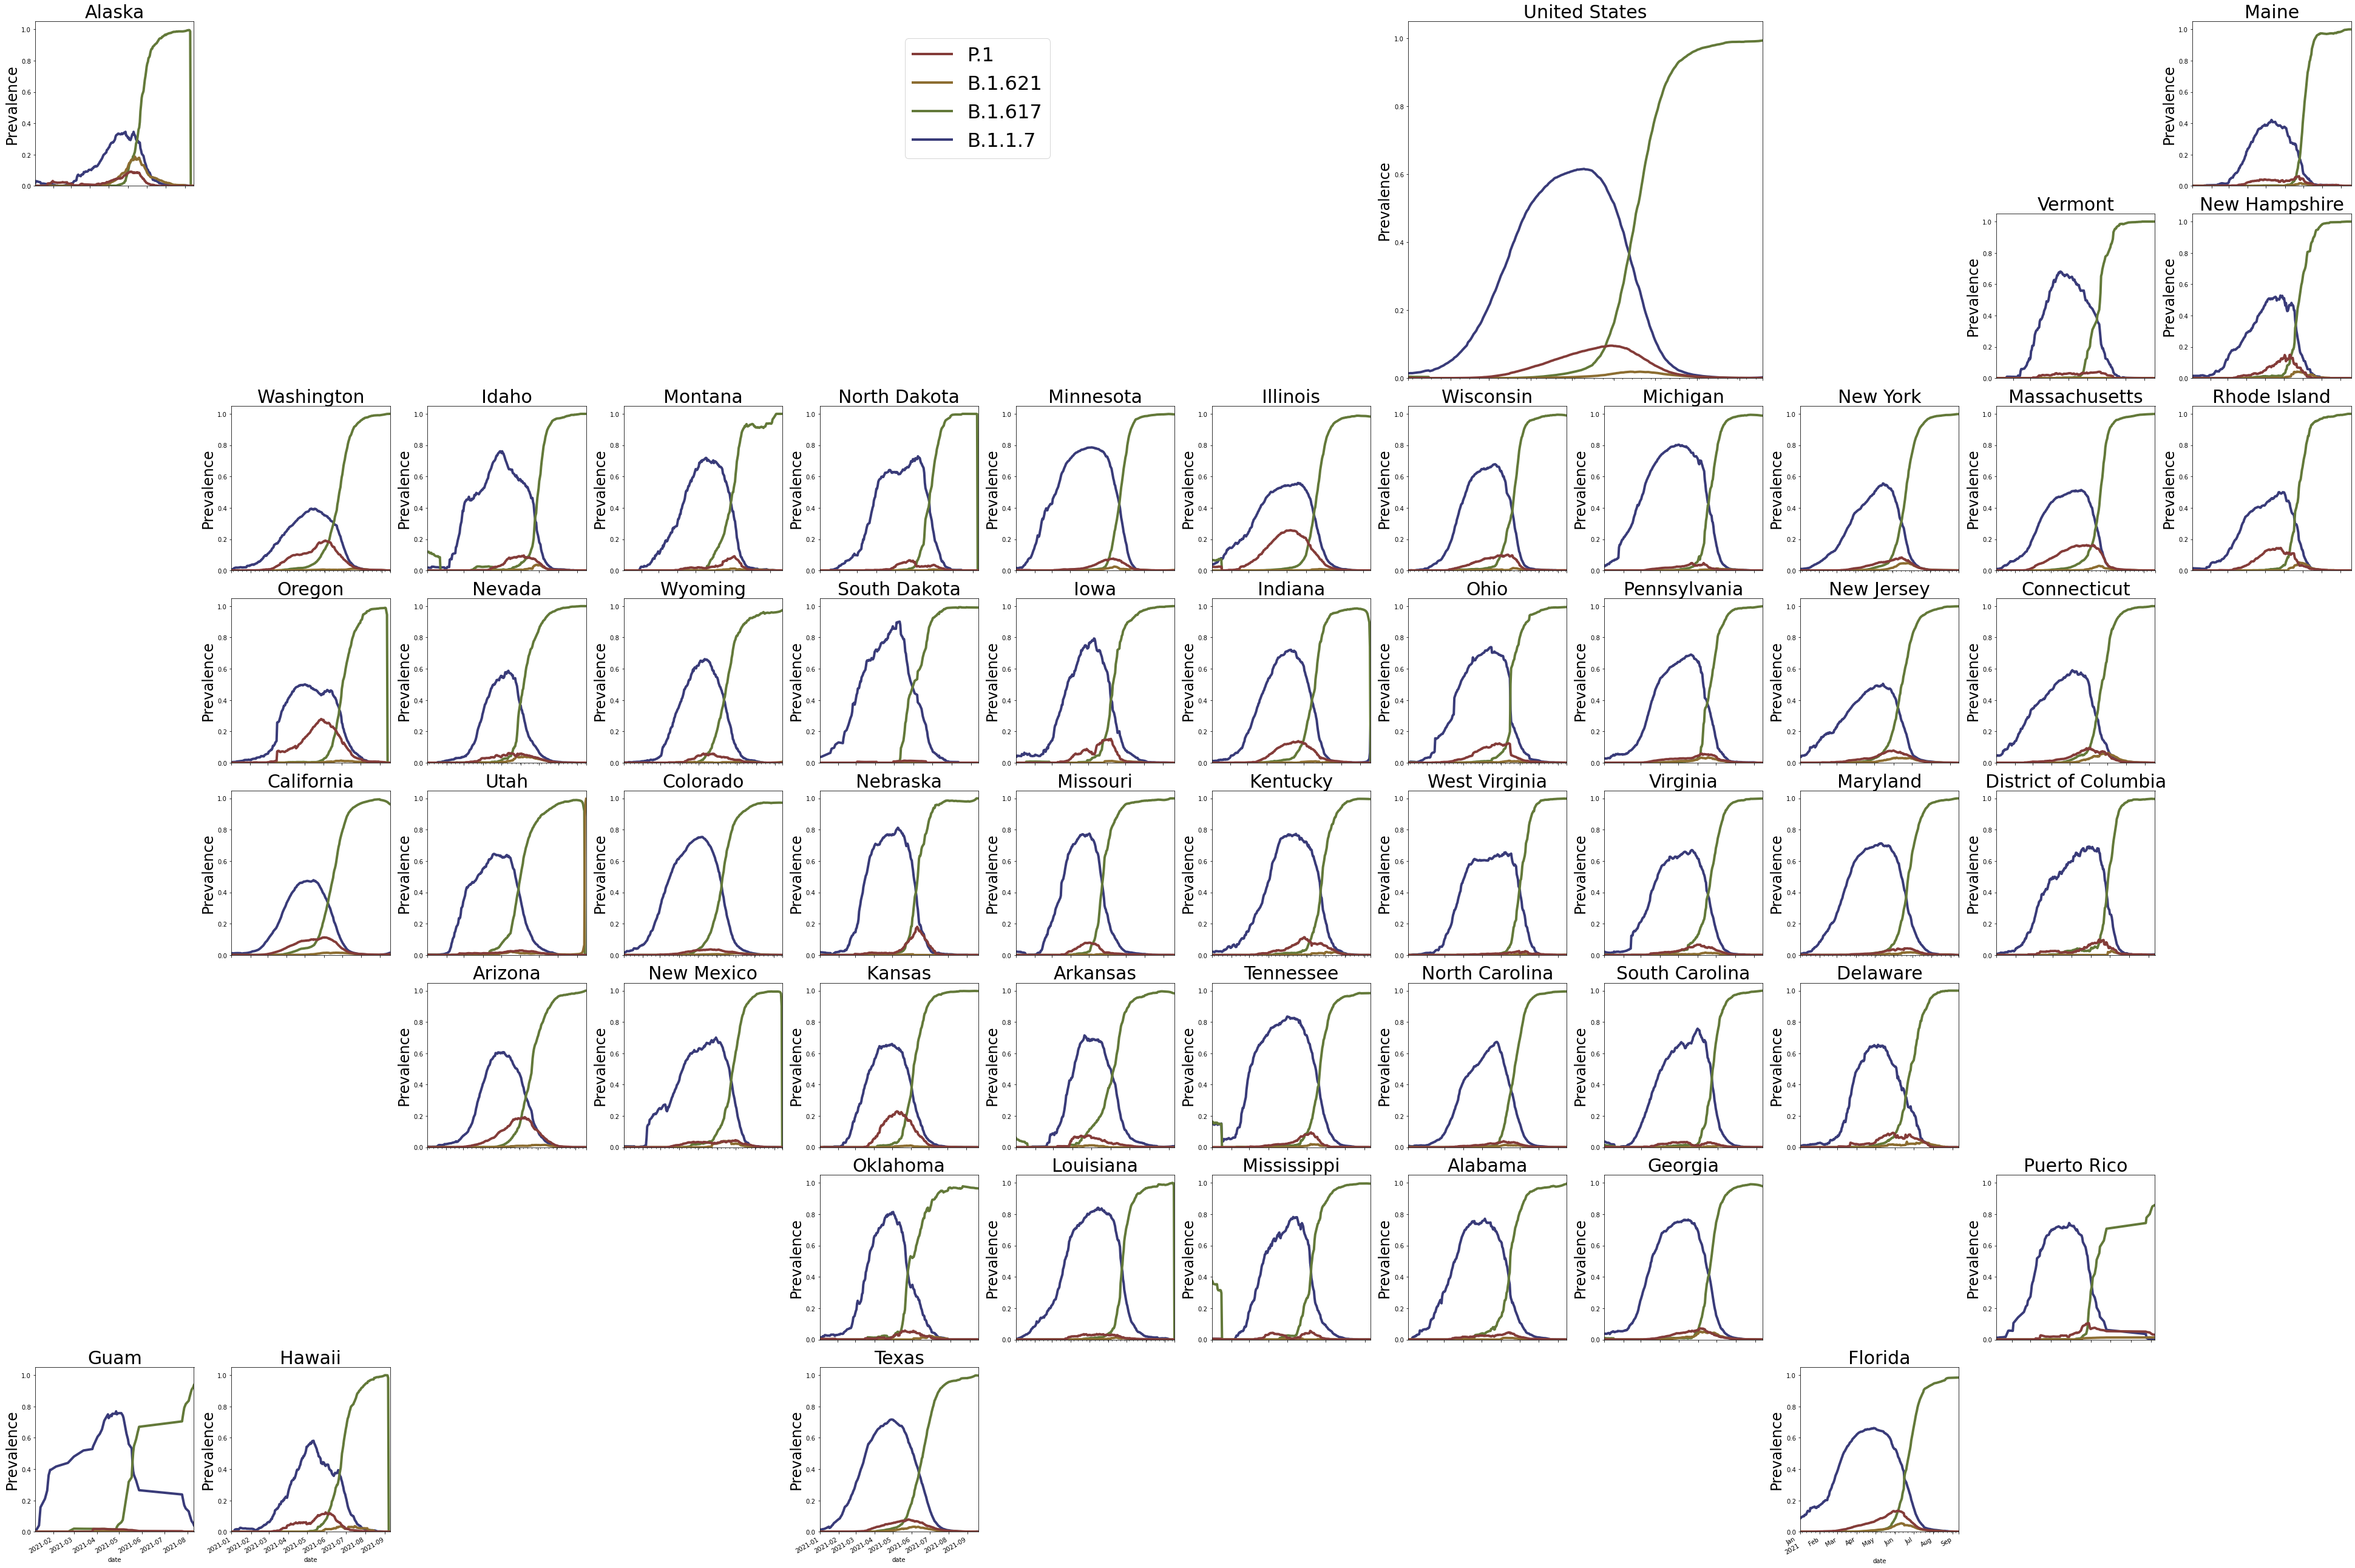

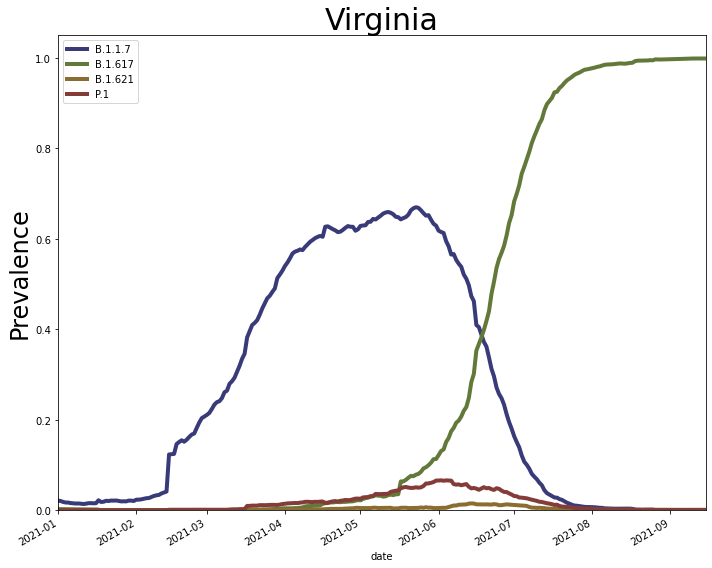

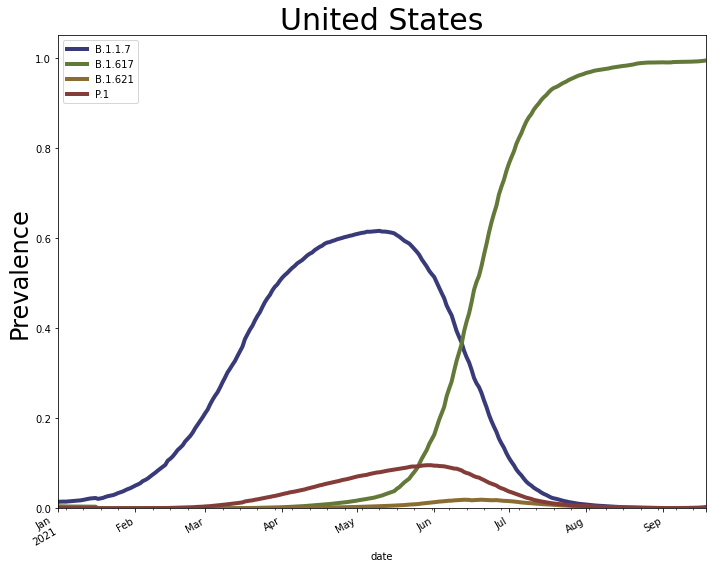

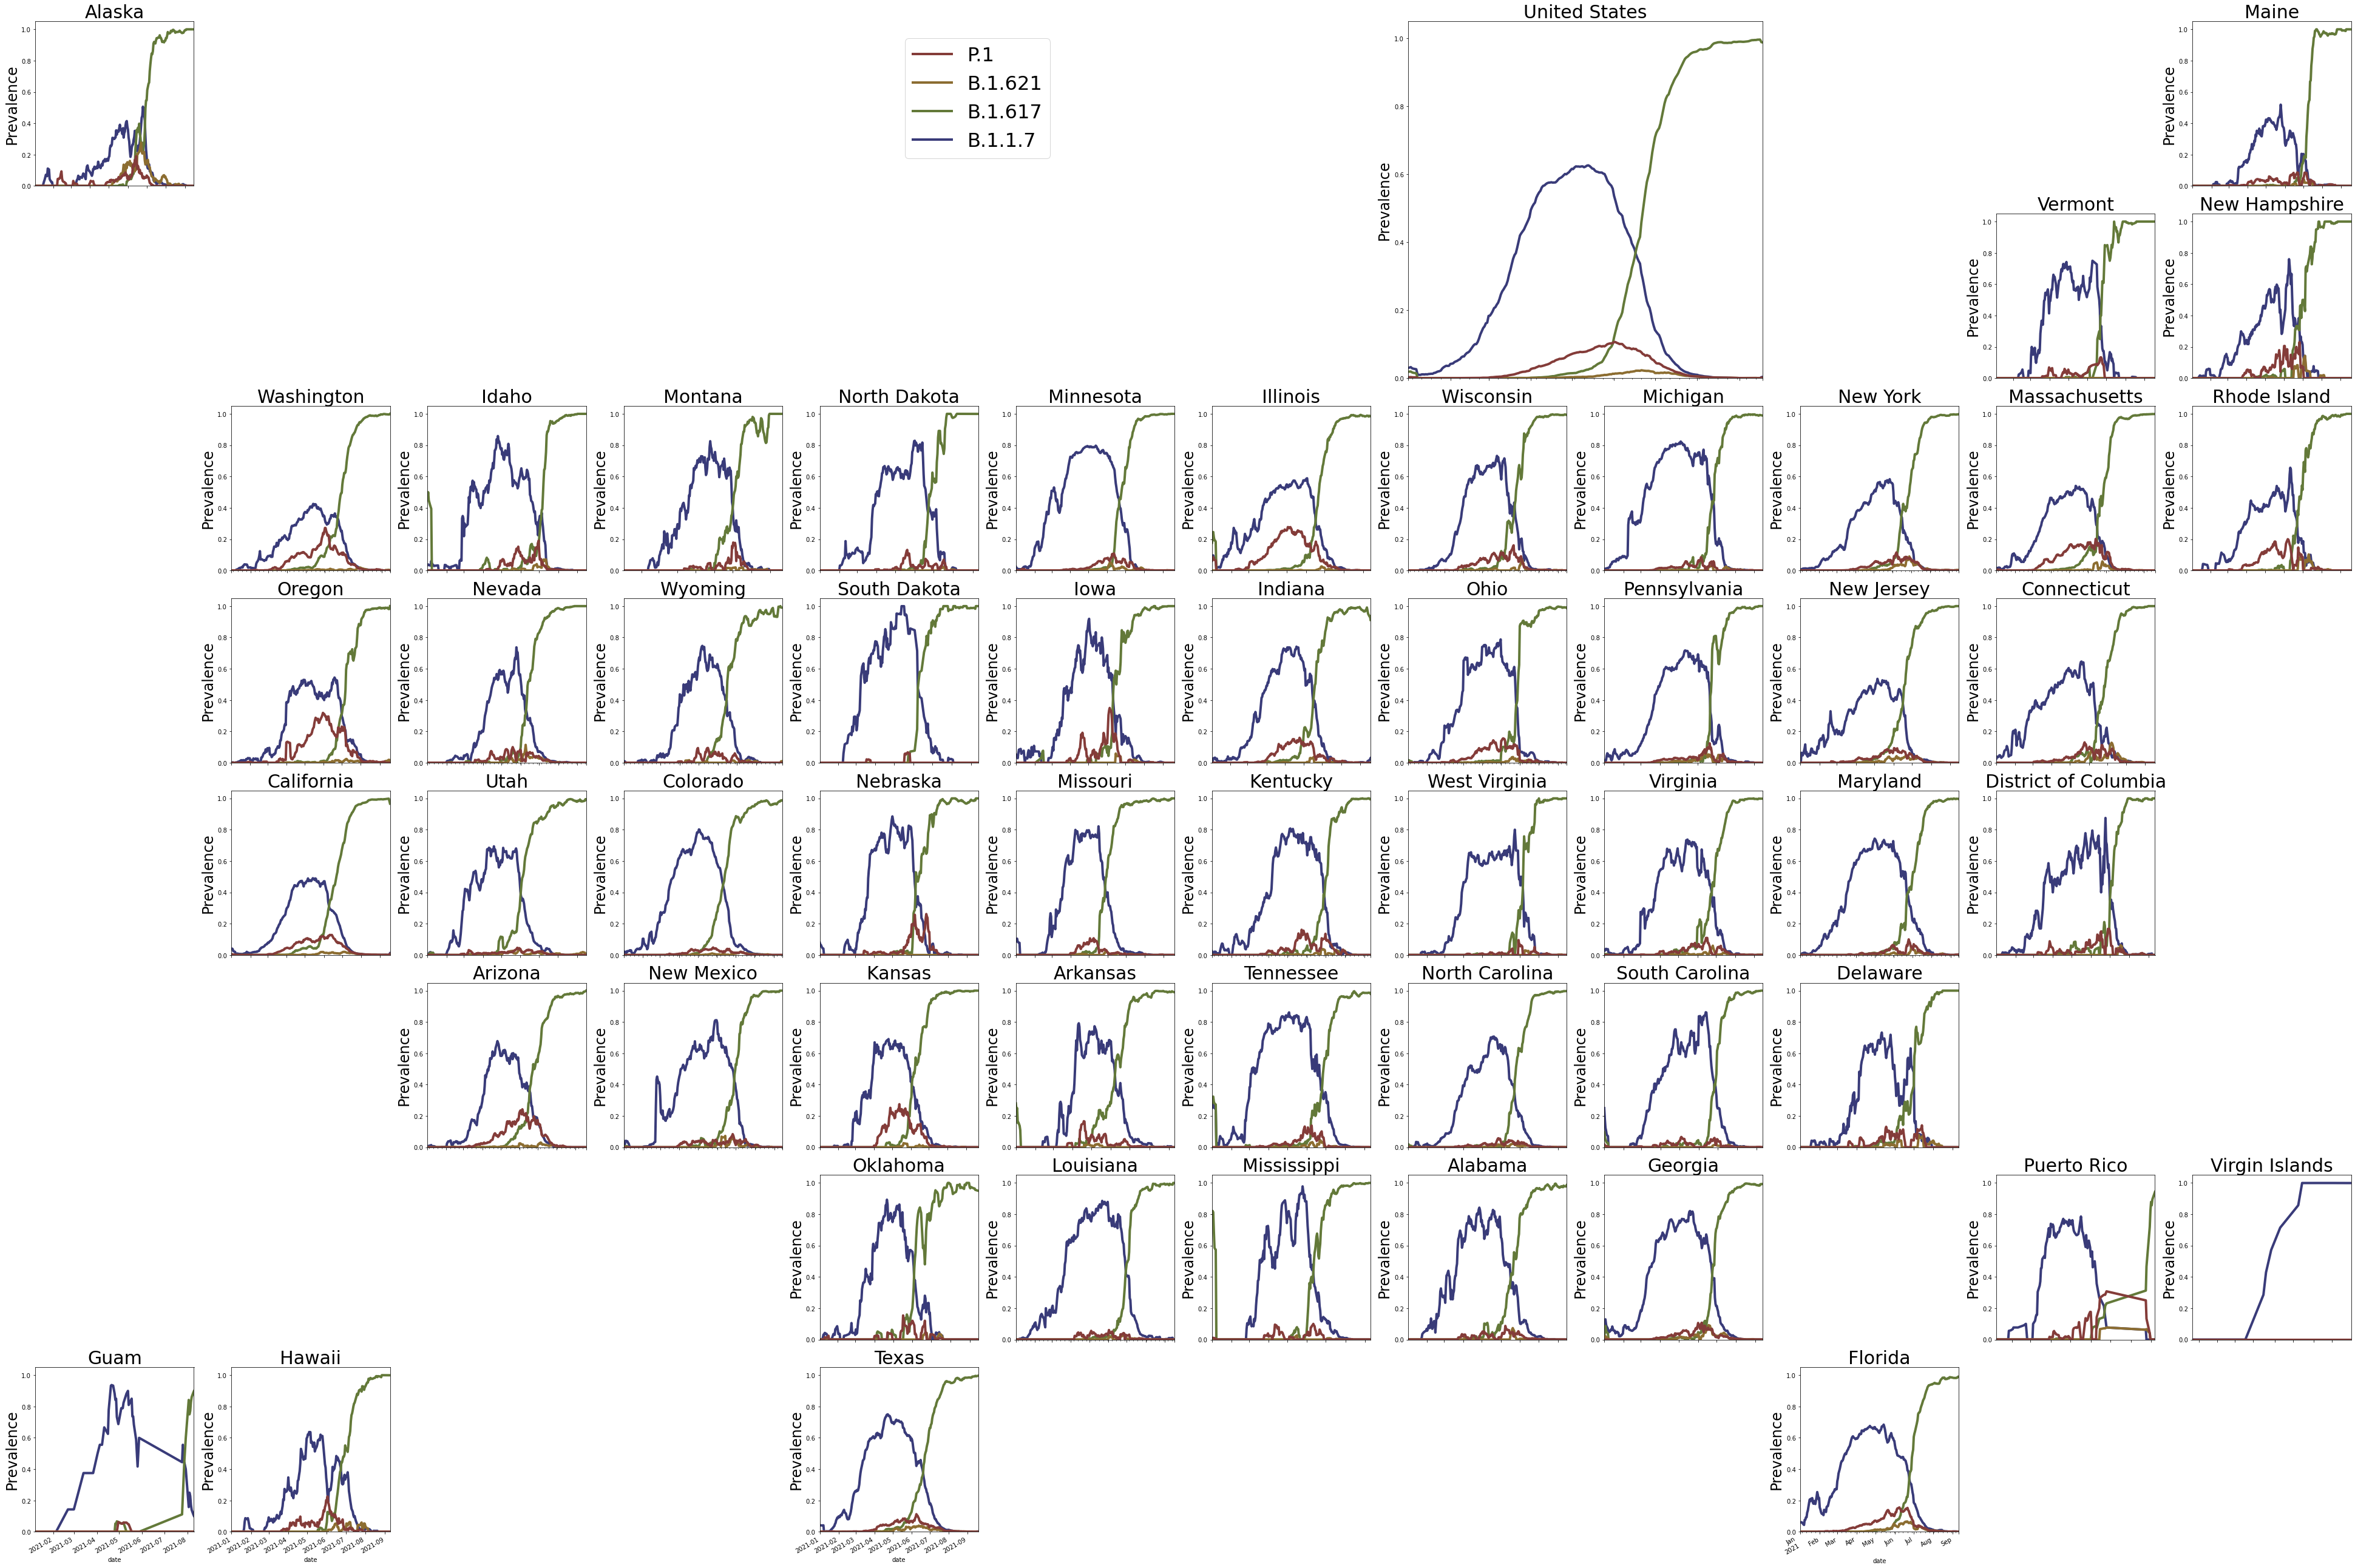

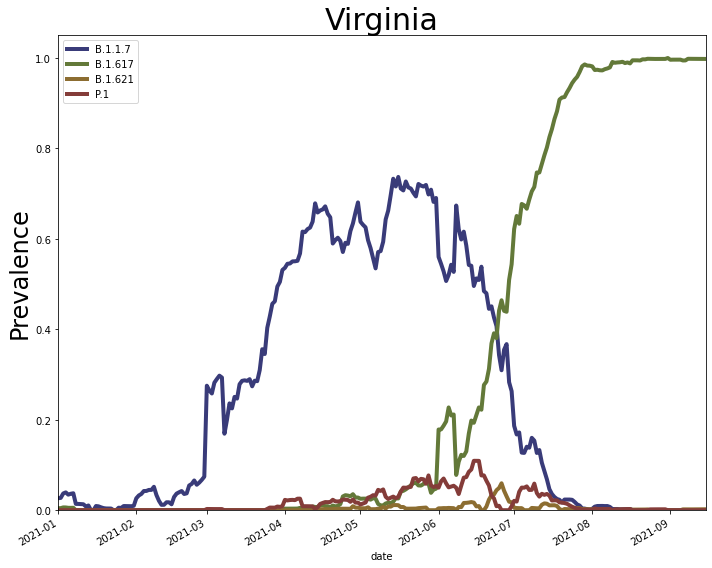

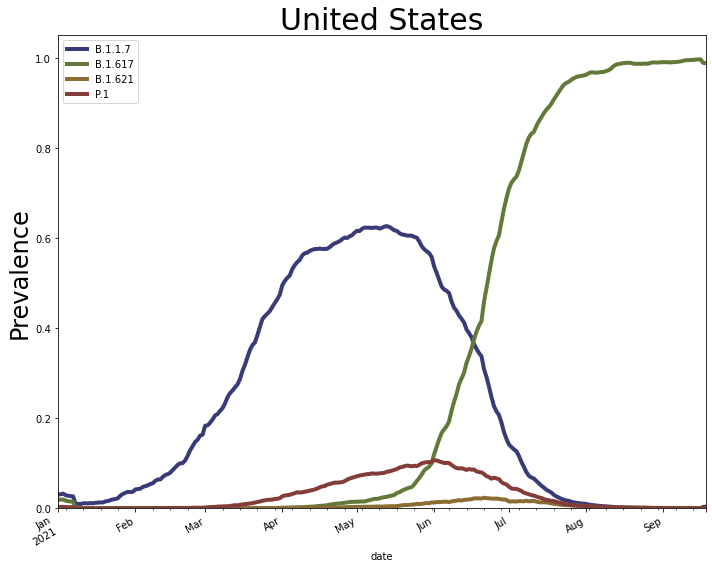

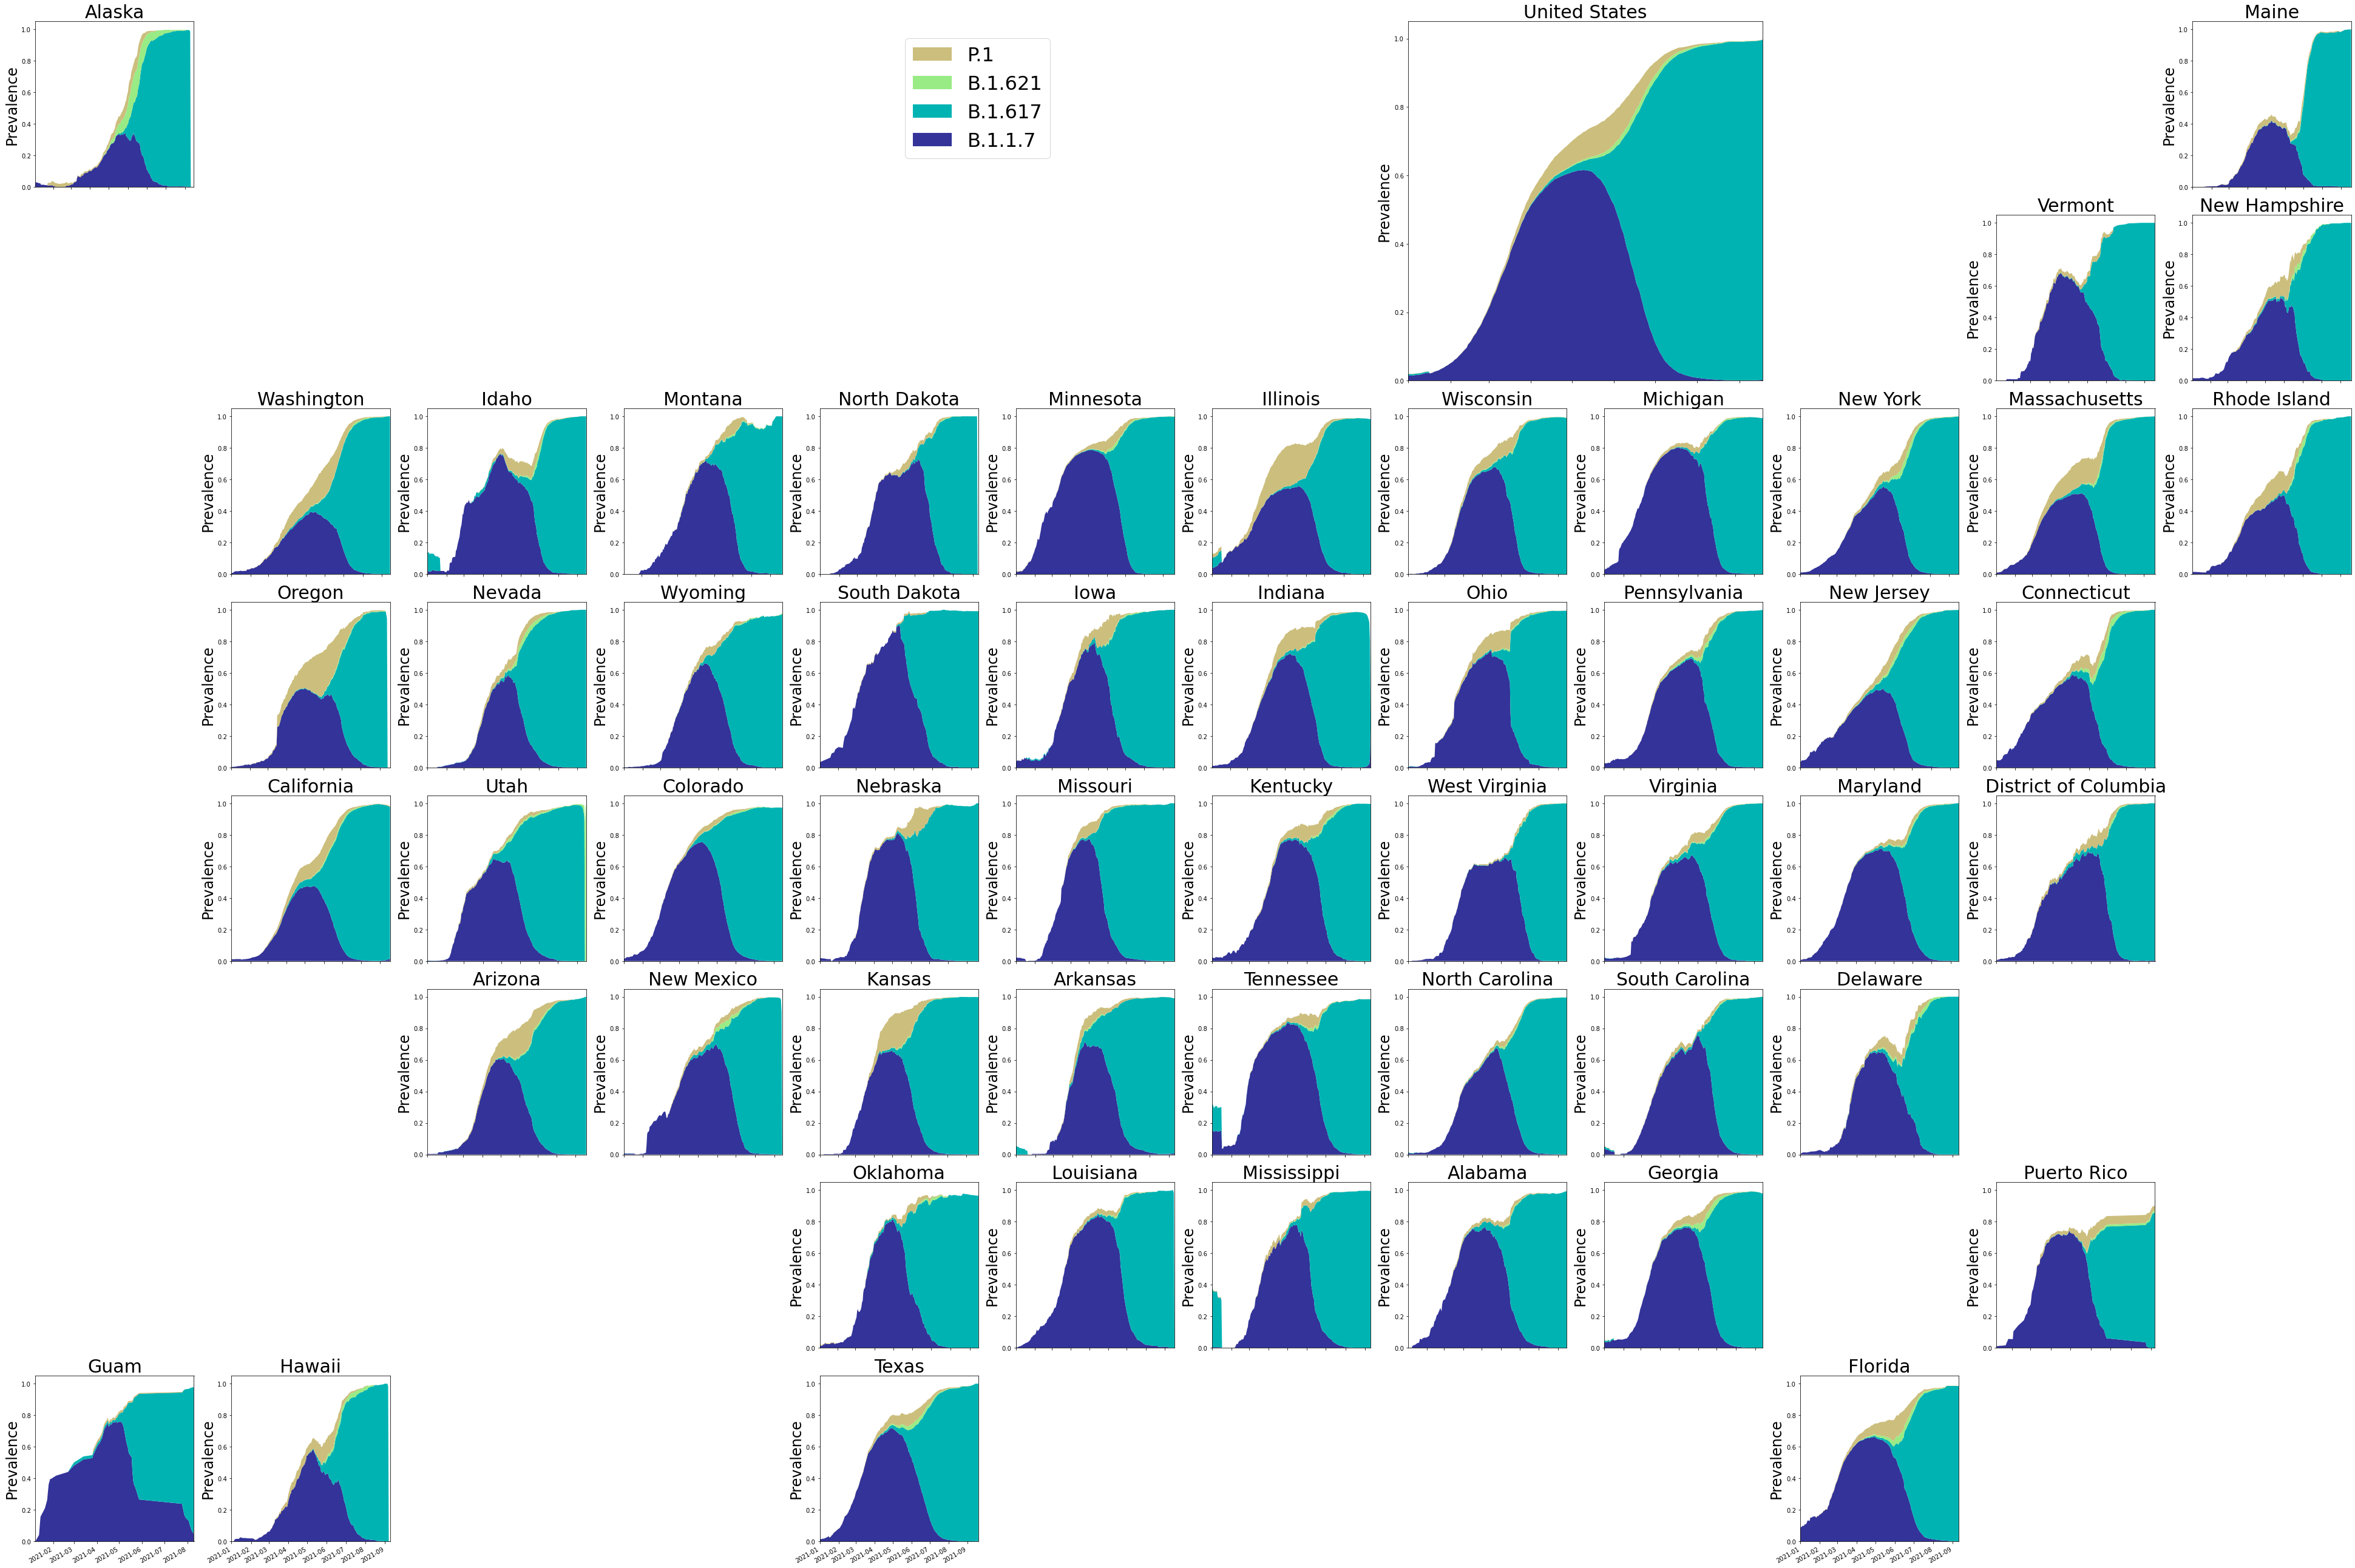

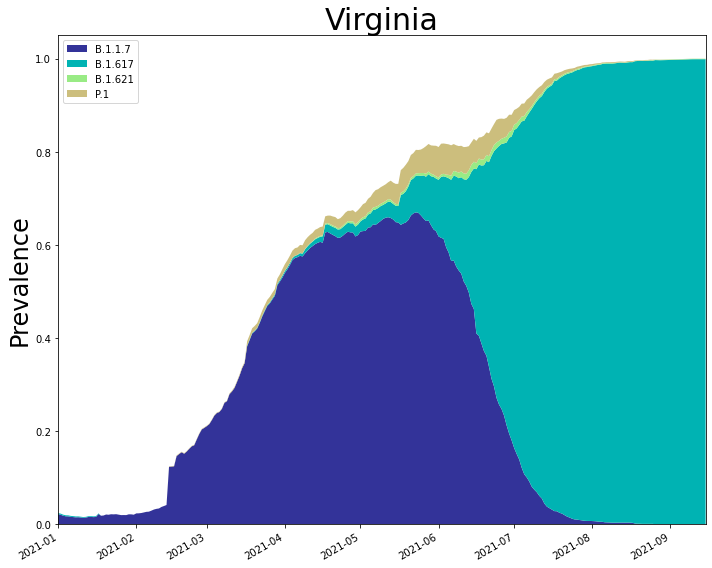

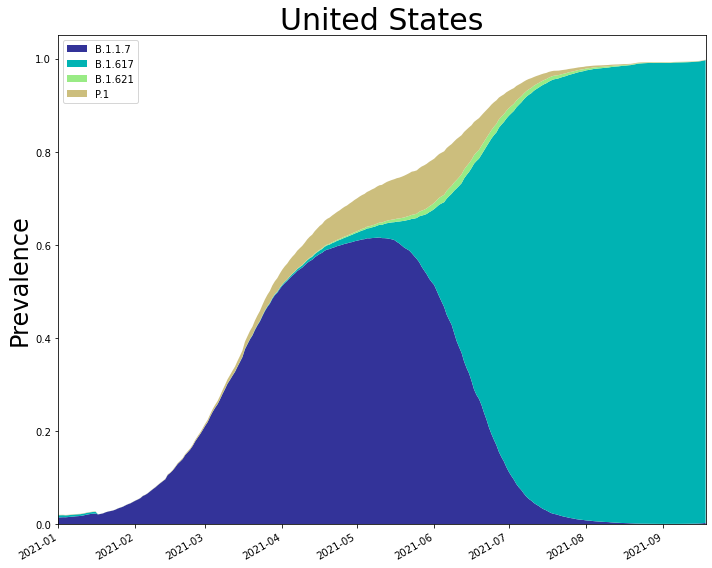

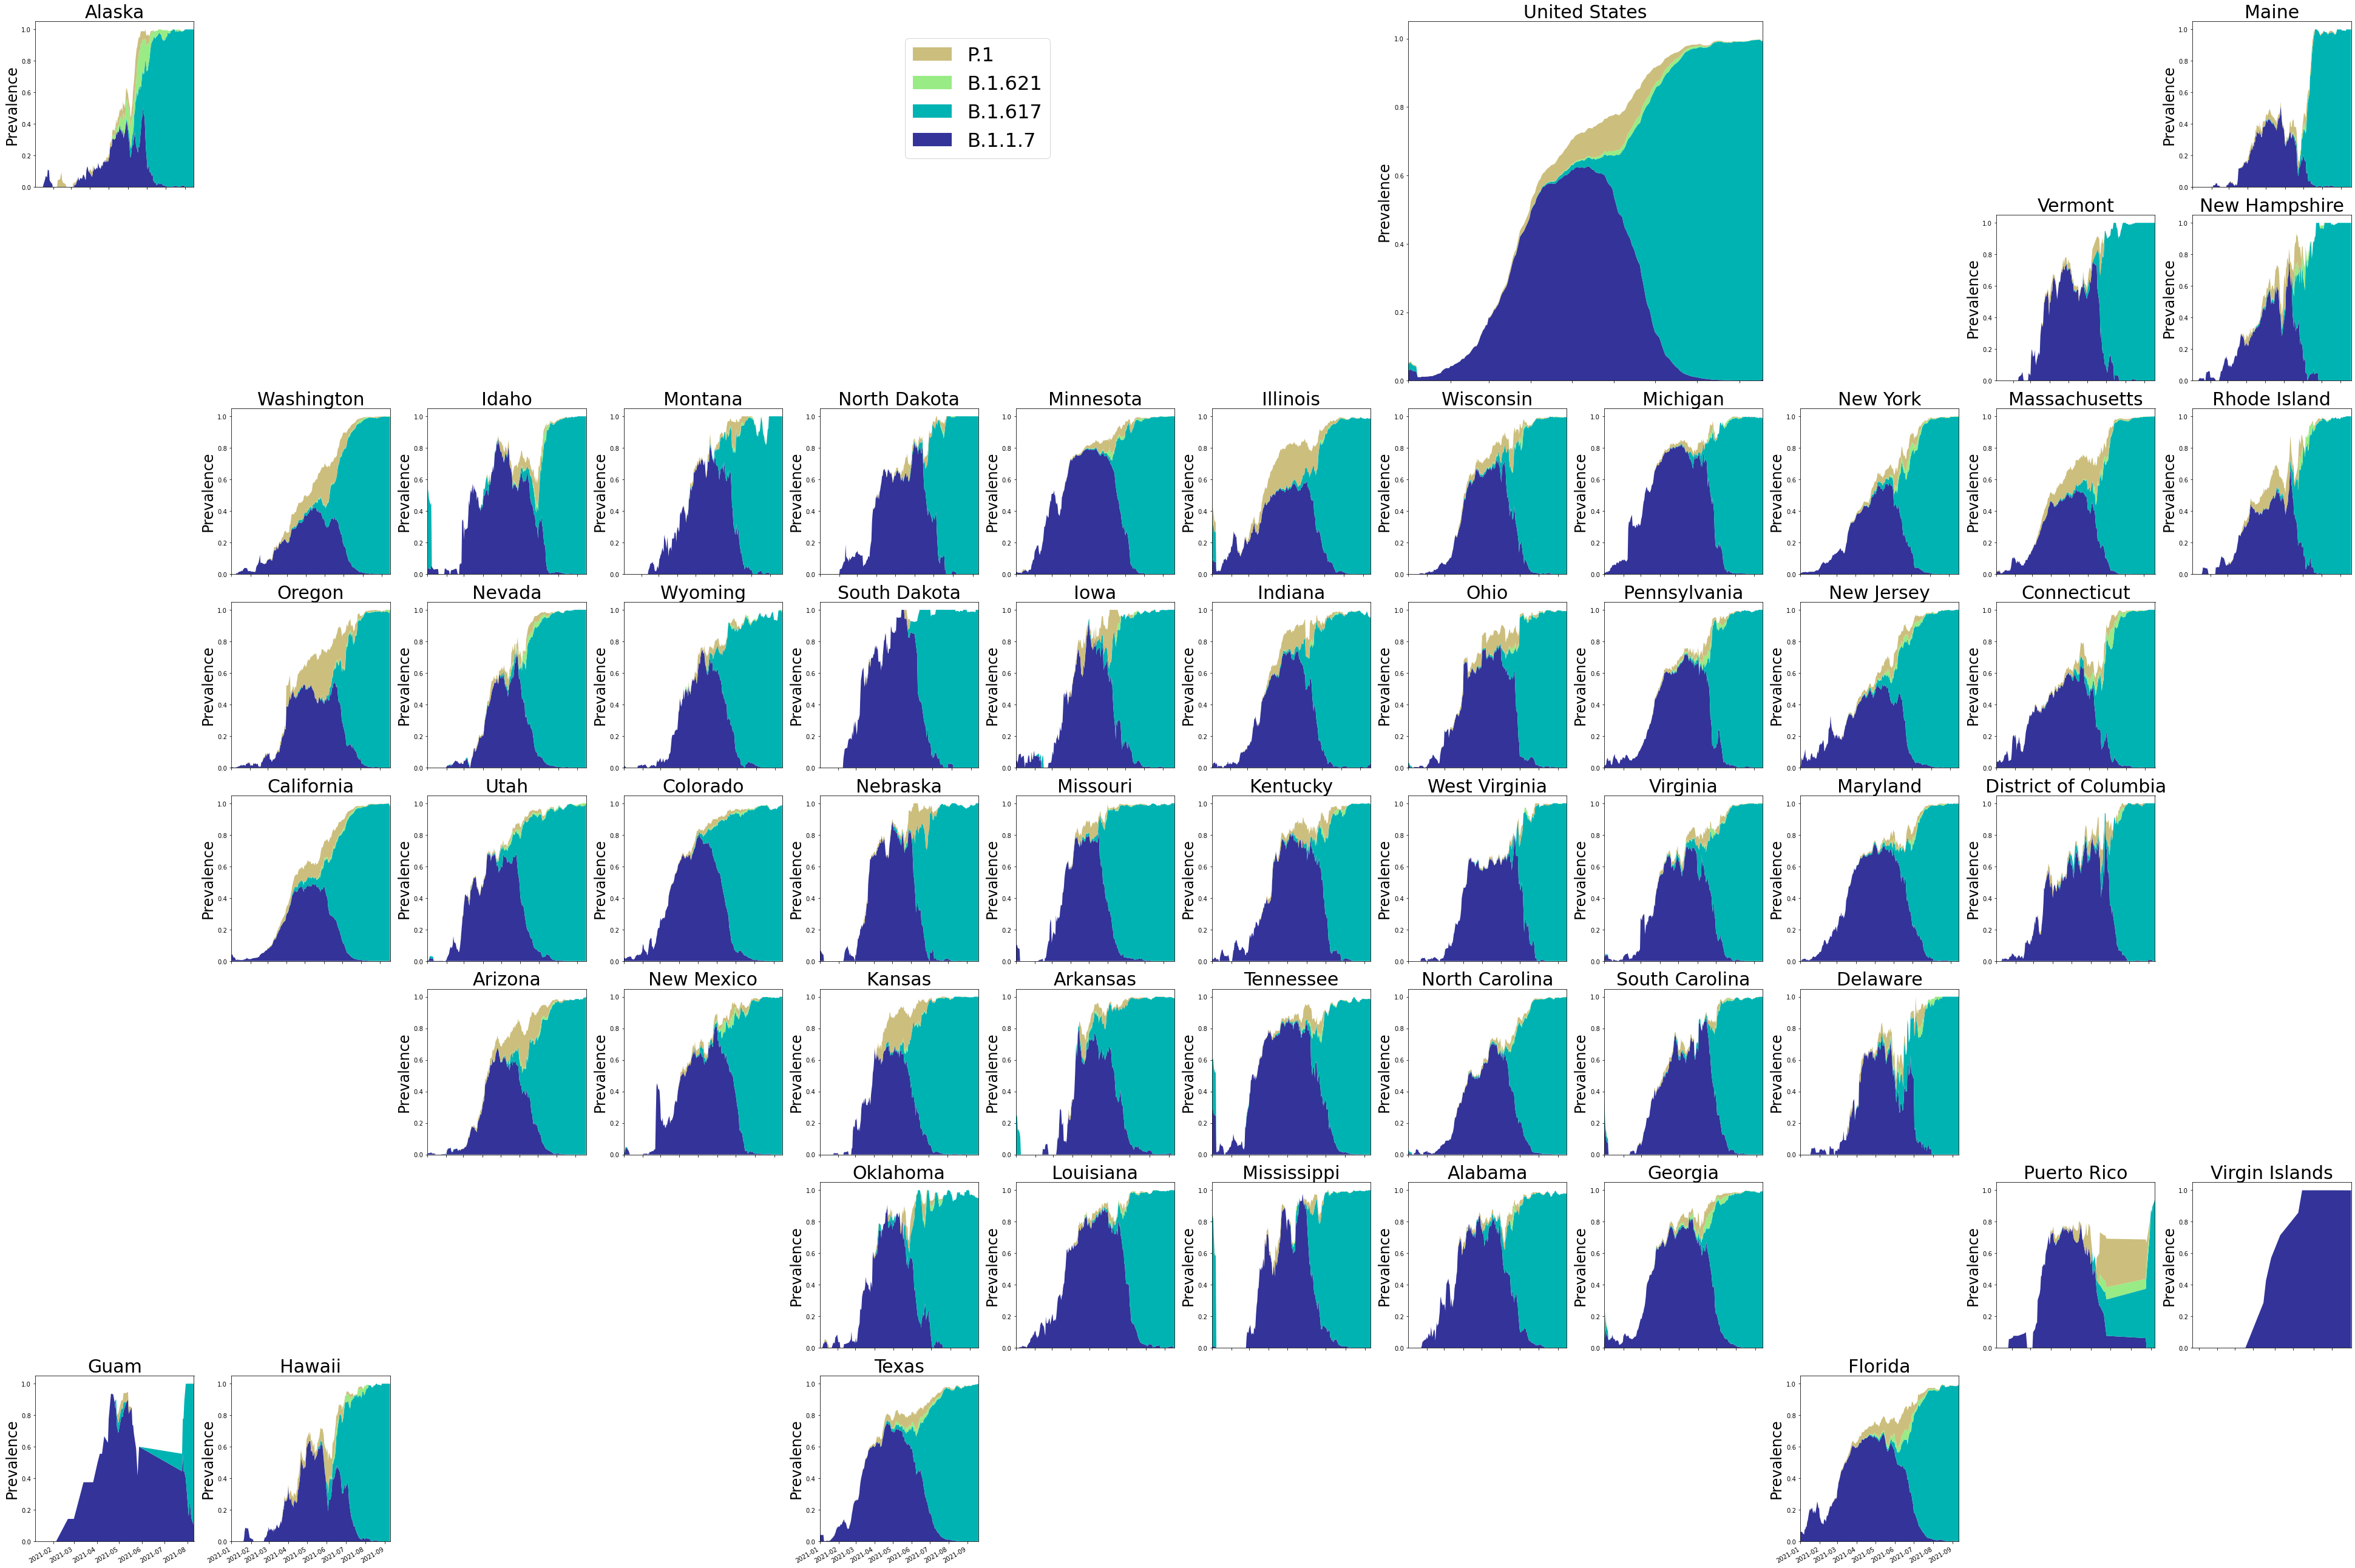

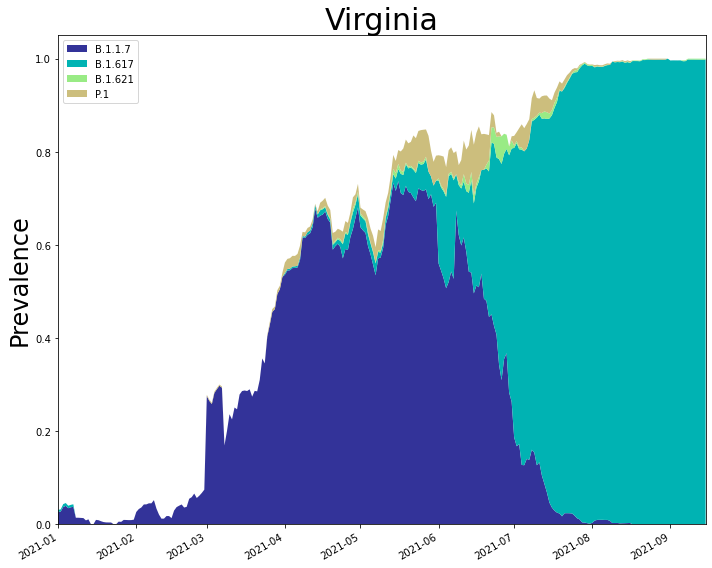

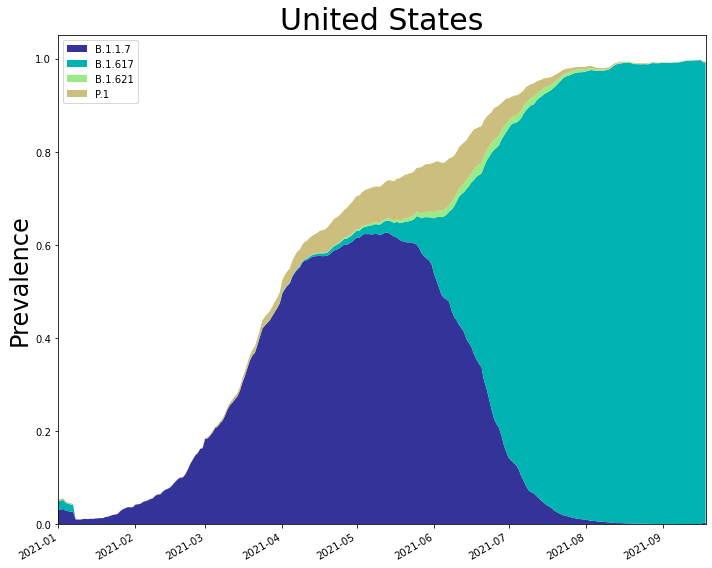

In [14]:
def get_us_grid():
    stat_notes = "/project/biocomplexity/COVID-19_commons/2019-nCoV_stat-analyses/notebooks/"
    state_hhs = pd.read_csv(stat_notes+'../misc_data/state_hhs_map.csv',usecols=[0,1,2,3],names=['sFIPS','HHS','state','StateName'],dtype=str)
    state_hhs['HHS'] = state_hhs.HHS.apply(lambda x: 'HHS Region {}'.format(x))
    us_df = pd.read_csv(stat_notes+'../misc_data/us_subplot_grid.csv')
    
    return us_df


def plot_gt(stackplot, rolling):
    
    rolling_str = "rolling" if rolling else "savgol"
    stackplot_str = "stackplot" if stackplot else "lines"
    stackplot_str = rolling_str + "_" + stackplot_str
    combine_str = "_substrains_combined" if combine_lineages else ""

    us_df = get_us_grid()
    fig = plt.figure(figsize=(54,36)) 
    gs = fig.add_gridspec(8,12)

    us_ax = fig.add_subplot(gs[0:2, 7:9])
    plot_state_variants("US", us_ax, stackplot=stackplot, rolling=rolling)
    # state_dfs["US"].plot(ax=us_ax, legend=False)
    # state_variant_prevalence.mean(axis=1).loc["2021-01-01":"2021-05-10"].plot(ax=us_ax, color="k", linestyle="--", alpha=0.6)    
    us_ax.set_title("United States", fontsize=30)
    us_ax.set_ylabel("Prevalence", fontsize=24)
    us_ax.set_ylim(0,1.05)
    us_ax.get_legend().remove()

    for r in range(8):
        for c in range(12):
            mask = (us_df.Row==r)&(us_df.Column==c)

            if len(us_df[mask])==0: # and not unseen_regions:
                pass
            else:
                ax = fig.add_subplot(gs[r,c])
                state = us_df[mask]['Name'].values[0]
                fips = state_to_stfips[state]

    #             state_variant_prevalence[state_to_stfips[state]].loc["2021-01-01":"2021-05-10"].plot(ax=ax, color="k", linestyle="--", alpha=0.6, label="B117 Adaptive Prevalence")
    #             abbr = state_to_state_abbr[state]
                try:
                    plot_state_variants(fips, ax, stackplot=stackplot, rolling=rolling)
                except:
                    ax.set_visible(False)
                    continue
                ax.set_title(state, fontsize=30)
                ax.set_ylabel("Prevalence", fontsize=24)
                ax.set_ylim(0,1.05)
#                 ax.axhline(0.05, label = None, linestyle="--", color="k")
                h1, l1 = ax.get_legend_handles_labels()
                ax.get_legend().remove()

    fig.autofmt_xdate()
    fig.legend(h1[::-1], l1[::-1], bbox_to_anchor=(0.45, 0.98), fontsize=32)
    plt.tight_layout()
#     plt.savefig(f"output/voc_prevalence_proportions_ground_truth_{stackplot_str}{combine_str}.png", dpi=100, bbox_inches="tight", facecolor="white")
    plt.savefig(f"/sfs/qumulo/qproject/biocomplexity/COVID-19_commons/data/variants/plots/voc_prevalence_proportions_ground_truth_{stackplot_str}{combine_str}.png", dpi=100, bbox_inches="tight", facecolor="white")
    
    fig, ax = plt.subplots(figsize=(10,8))
    plot_state_variants("51", ax, stackplot=stackplot, rolling=rolling)
    ax.set_title("Virginia", fontsize=30)
    ax.set_ylabel("Prevalence", fontsize=24)
    ax.set_ylim(0,1.05)
    ax.legend(loc="upper left")
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.savefig(f"/sfs/qumulo/qproject/biocomplexity/COVID-19_commons/data/variants/plots/VA_only_voc_prevalence_proportions_ground_truth_{stackplot_str}{combine_str}.png", dpi=100, bbox_inches="tight", facecolor="white")
    
    fig, ax = plt.subplots(figsize=(10,8))
    plot_state_variants("US", ax, stackplot=stackplot, rolling=rolling)
    ax.set_title("United States", fontsize=30)
    ax.set_ylabel("Prevalence", fontsize=24)
    ax.set_ylim(0,1.05)
    ax.legend(loc="upper left")
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.savefig(f"/sfs/qumulo/qproject/biocomplexity/COVID-19_commons/data/variants/plots/US_only_voc_prevalence_proportions_ground_truth_{stackplot_str}{combine_str}.png", dpi=100, bbox_inches="tight", facecolor="white")
    
# stackplot=True
# rolling=False

for stack in range(2):
    for roll in range(2):
        print(stack, roll)
        plot_gt(stack, roll)

0
1


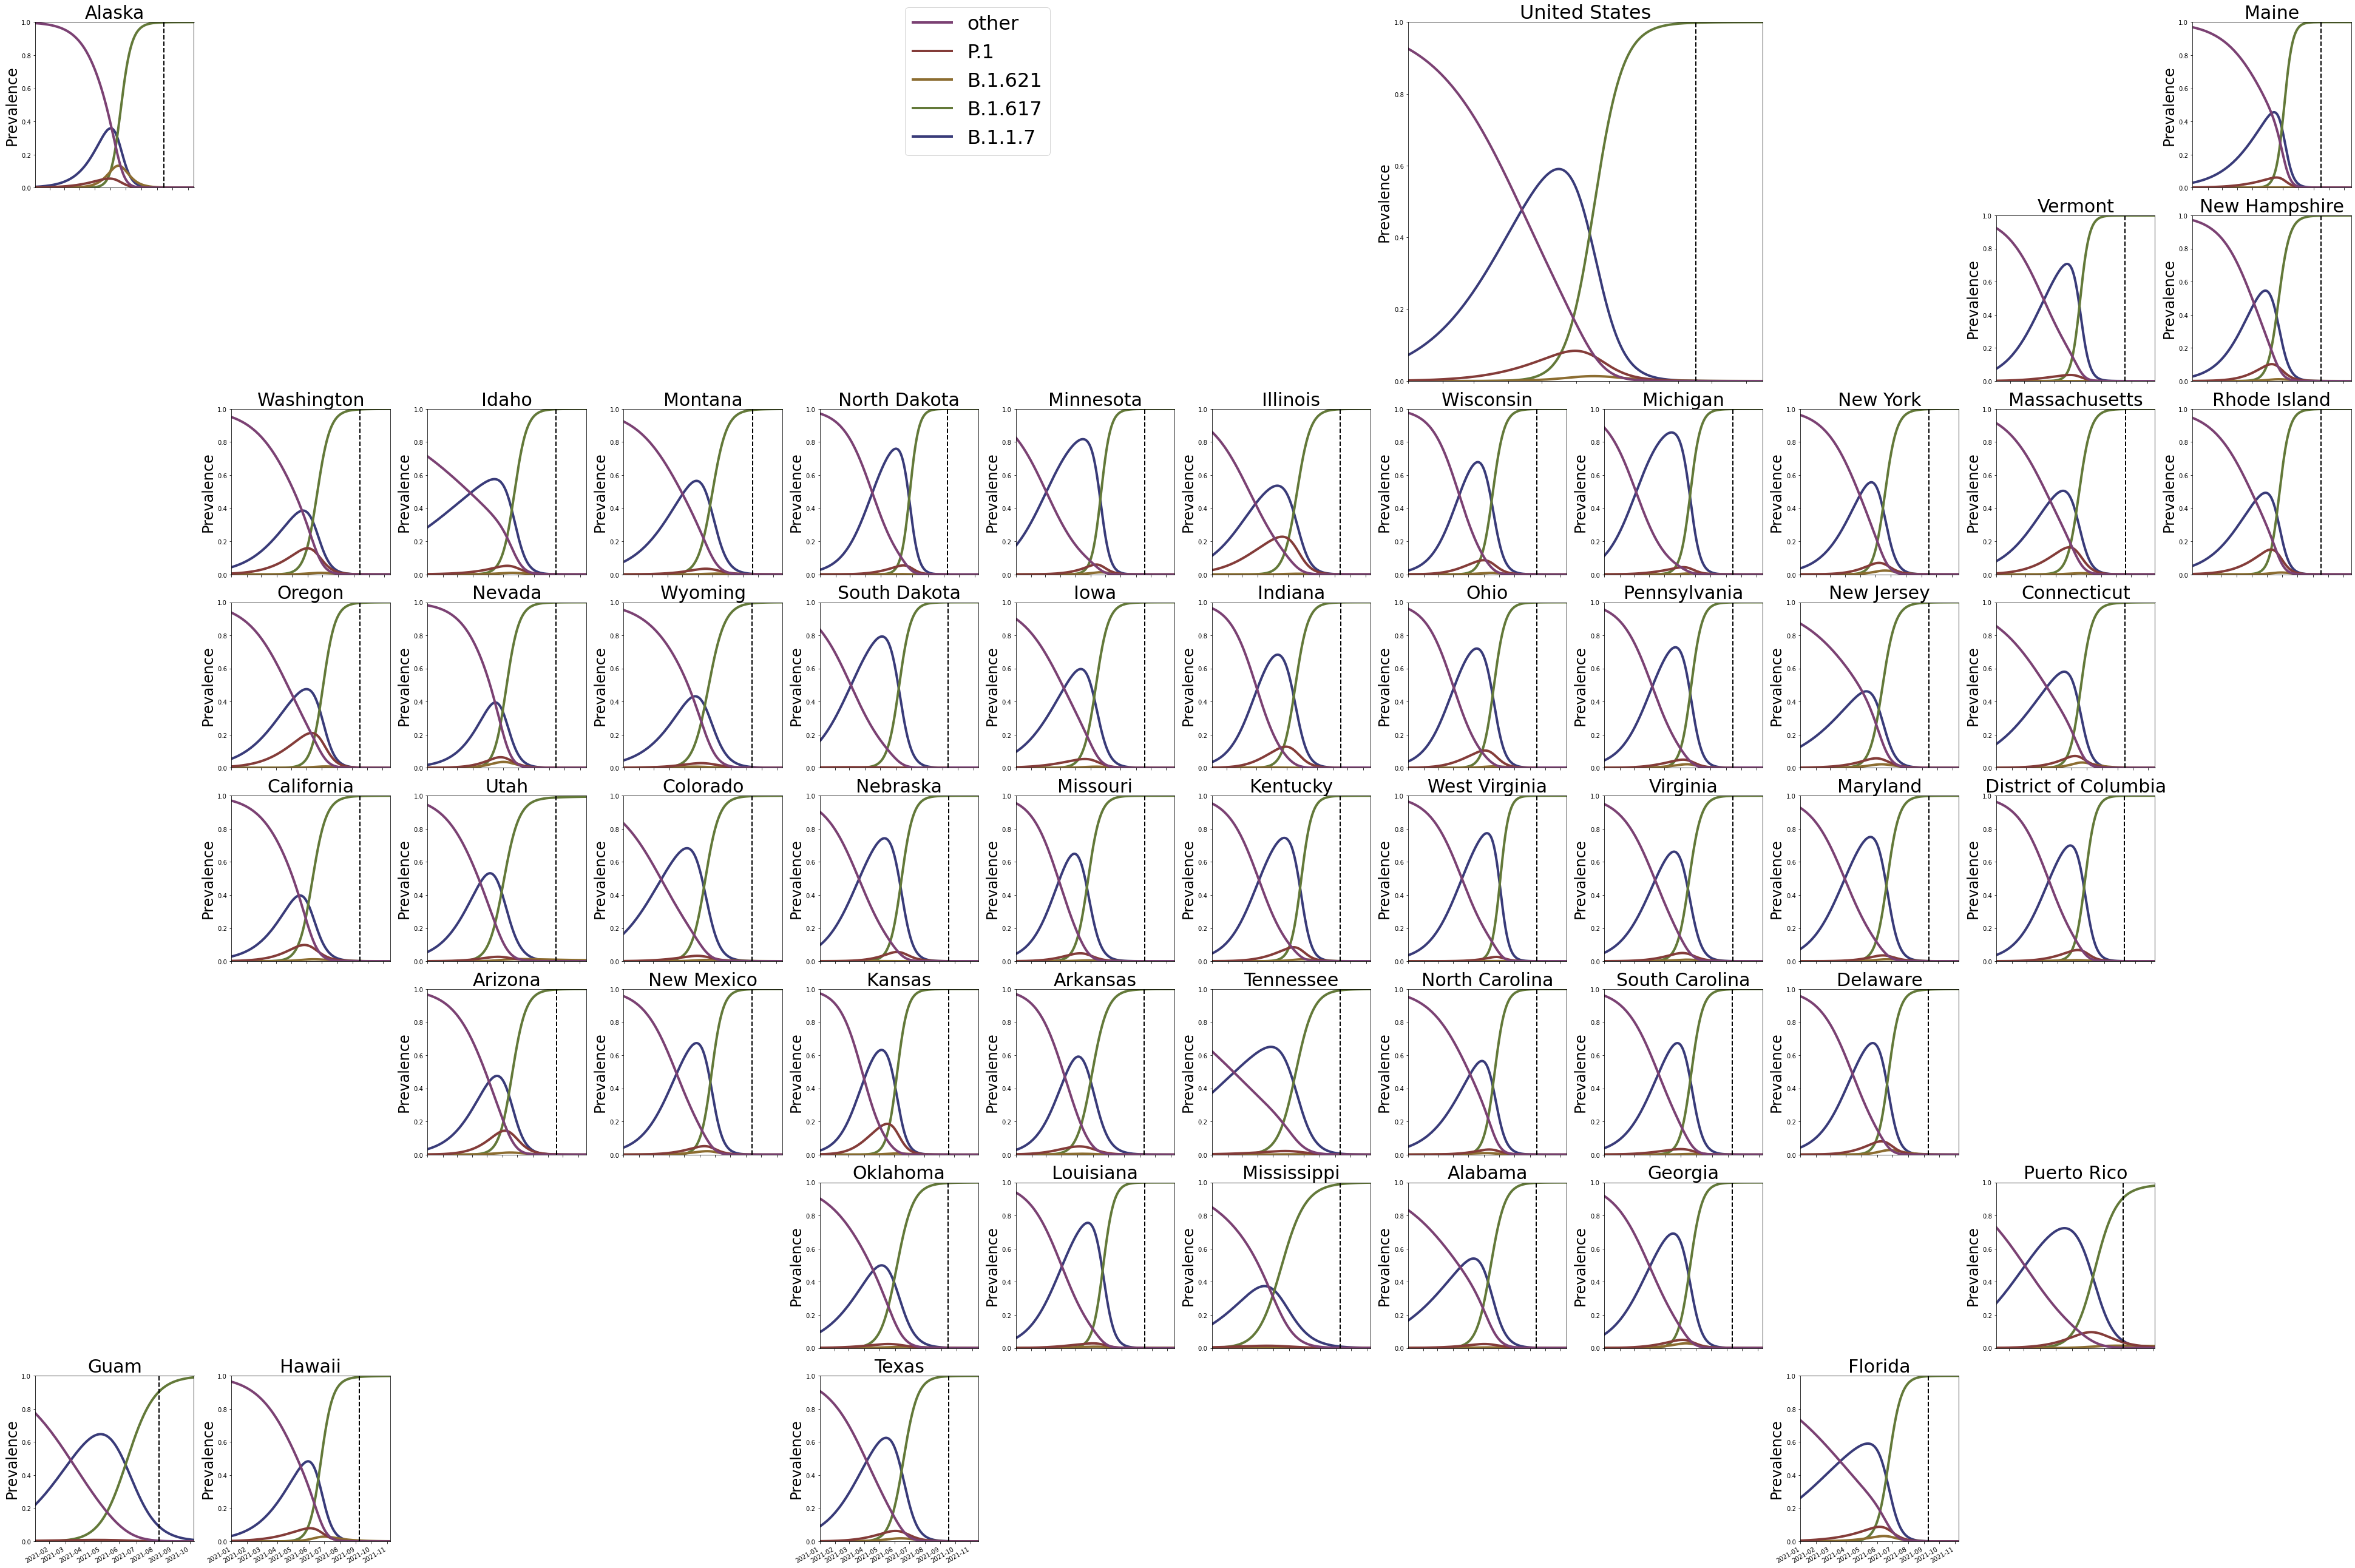

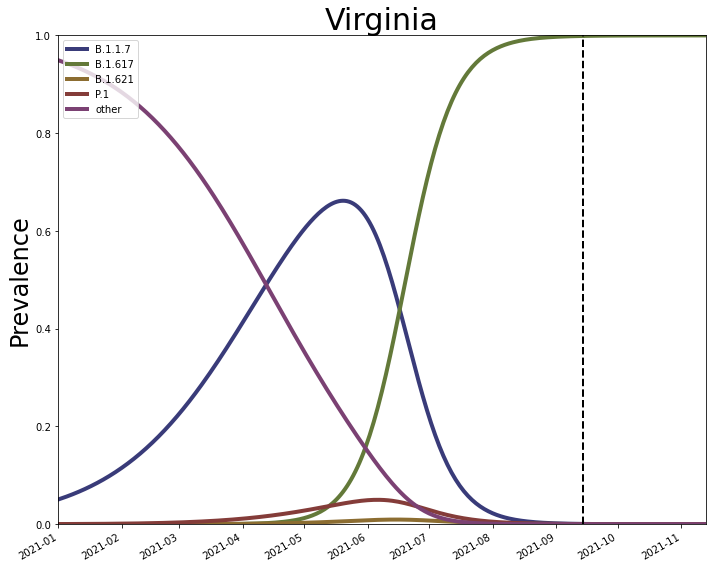

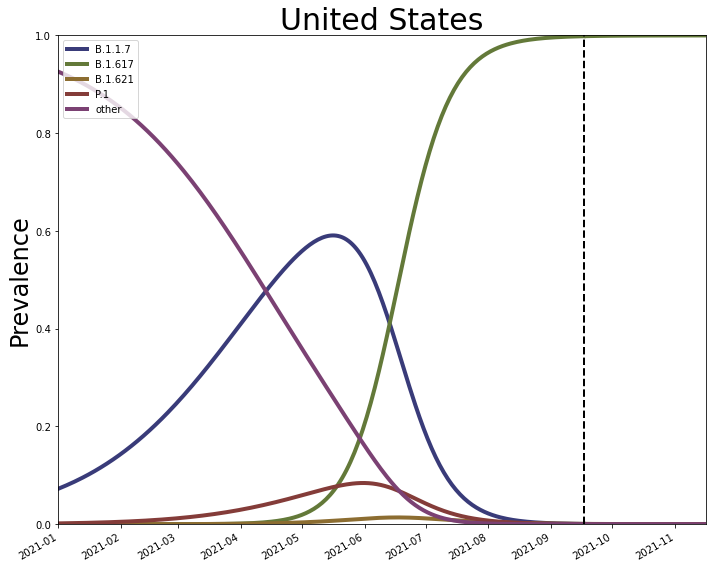

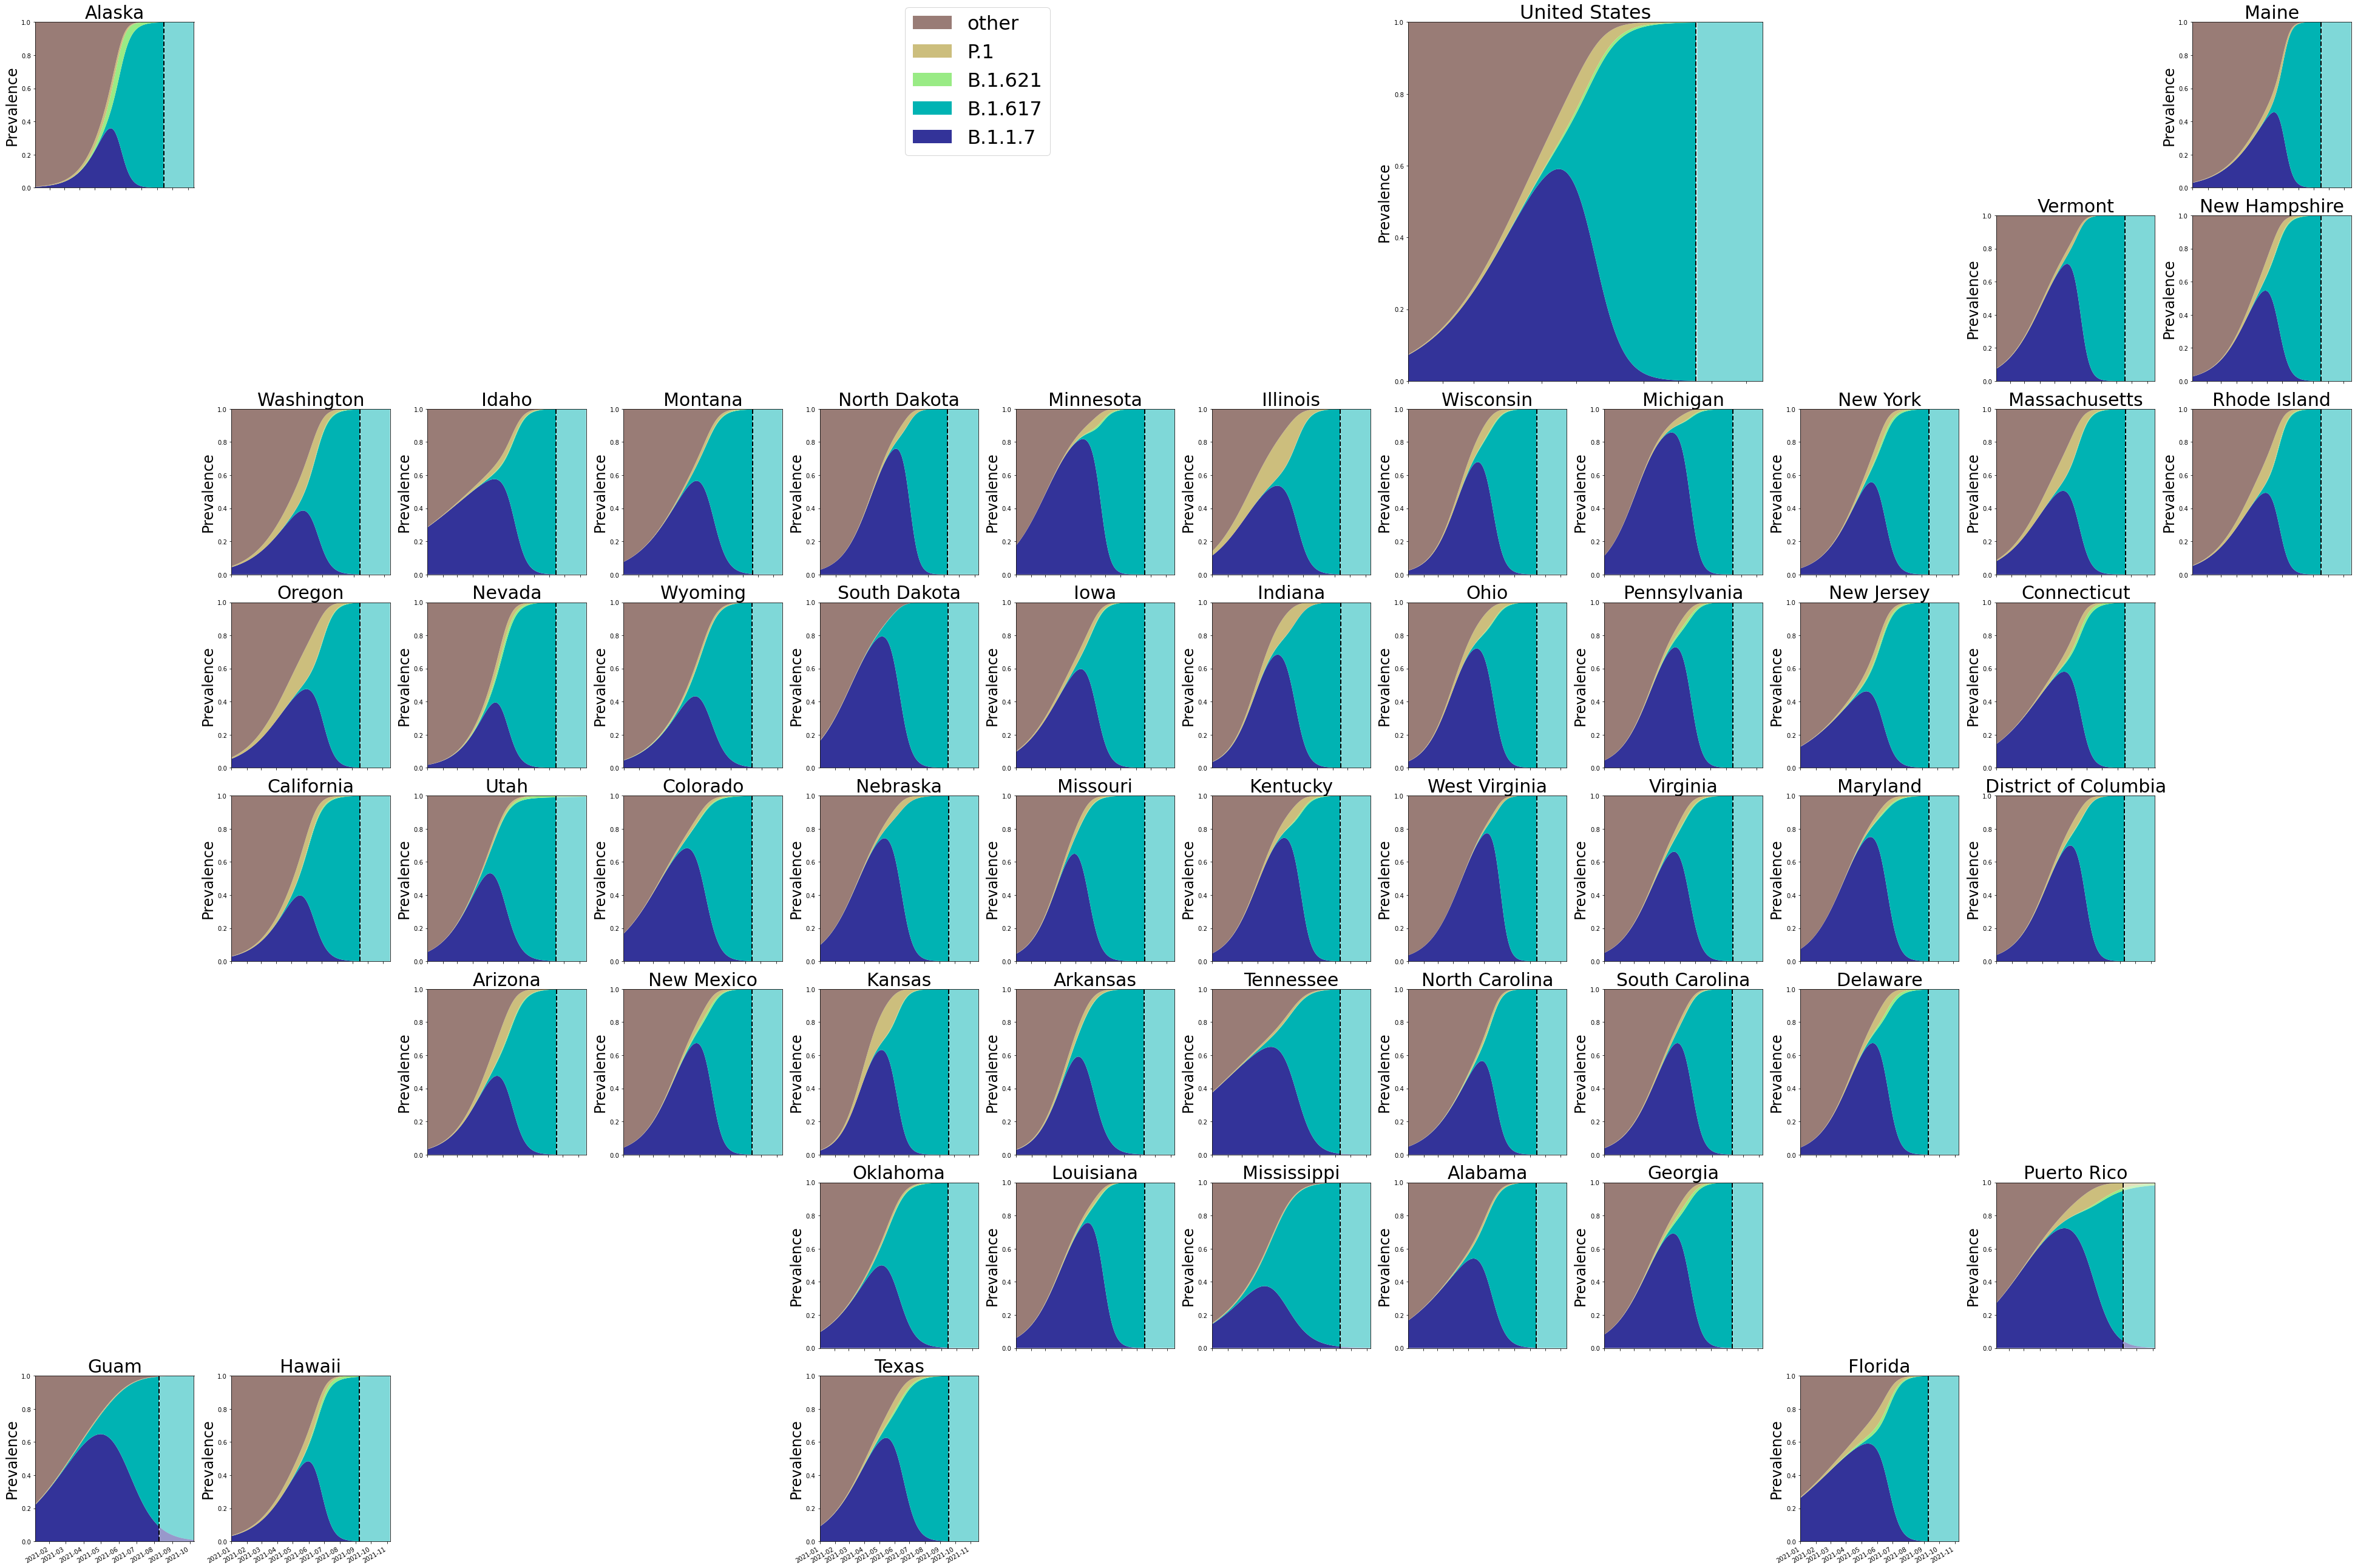

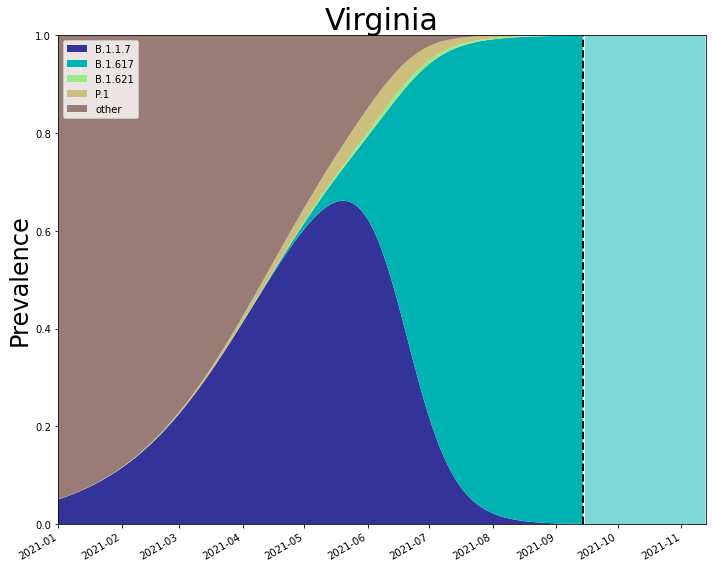

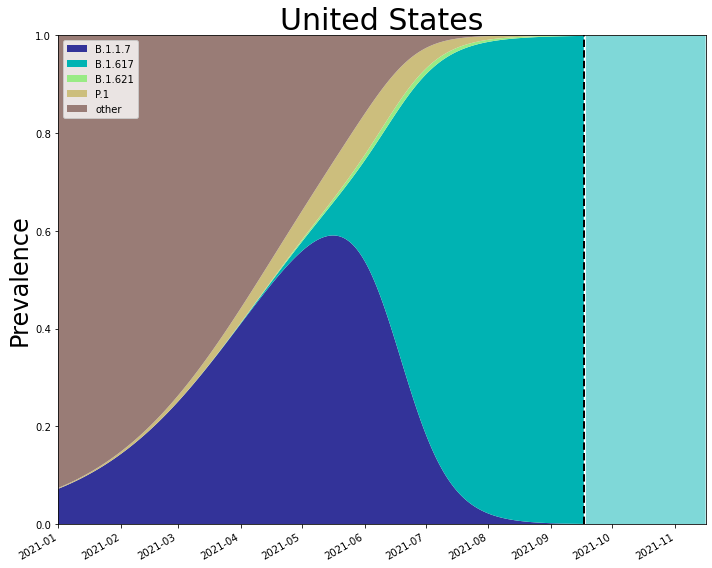

In [15]:
def get_us_grid():
    stat_notes = "/project/biocomplexity/COVID-19_commons/2019-nCoV_stat-analyses/notebooks/"
    state_hhs = pd.read_csv(stat_notes+'../misc_data/state_hhs_map.csv',usecols=[0,1,2,3],names=['sFIPS','HHS','state','StateName'],dtype=str)
    state_hhs['HHS'] = state_hhs.HHS.apply(lambda x: 'HHS Region {}'.format(x))
    us_df = pd.read_csv(stat_notes+'../misc_data/us_subplot_grid.csv')
    
    return us_df

def plot_predictions(stackplot):
    state_preds = []
    dates = []
    stackplot_str = "stackplot" if stackplot else "lines"
    combine_str = "_substrains_combined" if combine_lineages else ""
    
    us_df = get_us_grid()
    fig = plt.figure(figsize=(54,36)) 
    gs = fig.add_gridspec(8,12)

    us_ax = fig.add_subplot(gs[0:2, 7:9])
    plot_variant_predictions("US", us_ax, stackplot=stackplot)
    us_ax.set_title("United States", fontsize=32)
    us_ax.set_ylabel("Prevalence", fontsize=24)
    us_ax.get_legend().remove()

    for r in range(8):
        for c in range(12):
            mask = (us_df.Row==r)&(us_df.Column==c)

            if len(us_df[mask])==0: # and not unseen_regions:
                pass
            else:
                ax = fig.add_subplot(gs[r,c])
                state = us_df[mask]['Name'].values[0]
                fips = state_to_stfips[state]
    #             print(fips)
                try:
                    h1, l1, samples, above_5_date_6172, variants = plot_variant_predictions(fips, ax, stackplot=stackplot)
                    dates.append((fips, above_5_date_6172))
                    state_preds.append((state, variants))
                except:
                    ax.set_visible(False)
                    continue
#                 ax.set_title(f"{state}\n{above_5_date_6172}", fontsize=30)
                ax.set_title(f"{state}", fontsize=30)
                ax.set_ylabel("Prevalence", fontsize=24)
    #             h1, l1 = ax.get_legend_handles_labels()
#                 ax.axhline(0.05, label = None, linestyle="--", color="k")
                ax.get_legend().remove()
                

    #         break
    #     break


    fig.autofmt_xdate()
    fig.legend(h1[::-1], l1[::-1], bbox_to_anchor=(0.45, 1), fontsize=32)
    plt.tight_layout()
#     plt.savefig(f"output/voc_prevalence_proportions_predictions_{stackplot_str}{combine_str}_617_and_friends.png", dpi=100, bbox_inches="tight", facecolor="white")
#     return dates
    plt.savefig(f"/sfs/qumulo/qproject/biocomplexity/COVID-19_commons/data/variants/plots/voc_prevalence_proportions_predictions_{stackplot_str}{combine_str}.png", dpi=100, bbox_inches="tight", facecolor="white")
    
    fig, ax = plt.subplots(figsize=(10,8))
    h1, l1, _, above_5_date_6172, _ = plot_variant_predictions("51", ax, stackplot=stackplot)
#     ax.set_title(f"Virginia\n{above_5_date_6172}", fontsize=30)
    ax.set_title(f"Virginia", fontsize=30)
    ax.set_ylabel("Prevalence", fontsize=24)
    ax.legend(h1, l1, loc="upper left")
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.savefig(f"/sfs/qumulo/qproject/biocomplexity/COVID-19_commons/data/variants/plots/VA_only_voc_prevalence_proportions_predictions_{stackplot_str}{combine_str}.png", dpi=100, bbox_inches="tight", facecolor="white")
    
    fig, ax = plt.subplots(figsize=(10,8))
    h1, l1, _, _, _ = plot_variant_predictions("US", ax, stackplot=stackplot)
    ax.set_title(f"United States", fontsize=30)
    ax.set_ylabel("Prevalence", fontsize=24)
    ax.legend(h1, l1, loc="upper left")
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.savefig(f"/sfs/qumulo/qproject/biocomplexity/COVID-19_commons/data/variants/plots/US_only_voc_prevalence_proportions_predictions_{stackplot_str}{combine_str}.png", dpi=100, bbox_inches="tight", facecolor="white")

    return state_preds


for stack in range(2):
    print(stack)
    state_preds = plot_predictions(stack)
    
#     break

In [16]:
total_preds = []
for state, df in state_preds:
    df = df.melt(ignore_index=False).reset_index().rename(columns={"index":"date"})
    df["state"] = state
    total_preds.append(df)
pd.concat(total_preds).to_csv(f"/project/biocomplexity/COVID-19_commons/data/variants/variant_sample_projections_by_state{combined_str}.csv", index=False)


In [ ]:
ds = [np.datetime64(d[1]) for d in dates if d[1] != "NaT"]

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
x = pd.DataFrame(ds, columns=["Date B.1.617.2 hits 5%"])
# x["count"] = 1
x.hist(ax=ax)
plt.savefig("five_percent_hist_from_multinomial_fit.png", dpi=100)

In [ ]:
mean = (np.array(ds, dtype='datetime64[s]')
        .view('i8')
        .mean()
        .astype('datetime64[s]'))

print(mean)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(18,8)) 
h1, l1, _ = plot_variant_predictions("51", axs[0], stackplot=stackplot)
h2, l2, _ = plot_variant_predictions("51", axs[1], stackplot=True)
axs[0].set_ylabel("Prevalence", fontsize=18)
axs[0].legend(h1, l1, fontsize=14)
axs[1].legend(h2, l2, fontsize=14)
axs[0].tick_params(axis="x", labelsize=16, rotation=45)
axs[1].tick_params(axis="x", labelsize=16, rotation=45)
plt.savefig("virginia_variant_multnomial_fit_VDH.png", dpi=100)

In [ ]:
fig, ax = plt.subplots(figsize=(10,8)) 
_, _, _ = plot_variant_predictions("51", ax, stackplot=True)

In [ ]:
# test = predict_variants("36")
# test = (test * 10000).applymap(floor)
# test = test.reset_index(drop=True).reset_index()
# test = test.melt(id_vars=["index"])
# test.columns = ["Generation", "Identity", "Population"]
# name_to_ix = {strain:ix for ix, strain in enumerate(sorted(test.Identity.unique())[::-1])}
# test.Identity = test.Identity.apply(lambda row: name_to_ix[row])

# adjacency = [(0, ix) for ix in range(1,len(test.Identity.unique()))]
# adjacency = pd.DataFrame.from_records(adjacency, columns = ["Parent", "Identity"])
